In [47]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

from grnndata import read_h5ad
import numpy as np
import tqdm
import os

#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc

from scprint2 import scPRINT2
from scprint2.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
import scanpy as sc
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import scipy.sparse

from scdataloader.utils import load_genes
import anndata as ad
import bionty as bt
from grnndata import from_adata_and_longform

import torch

torch.set_float32_matmul_precision("medium")

%load_ext autoreload
%autoreload 2

LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data"  #

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# (OPTIONAL) Loading the human interactome gene network


In [ ]:
! wget --no-check-certificate -O $LOC/RF2-PPI.gz https://conglab.swmed.edu/humanPPI/downloads/RF2-PPI_scores.gz
! wget --no-check-certificate -O $LOC/DCA_scores.gz https://conglab.swmed.edu/humanPPI/downloads/DCA_scores.gz
! wget --no-check-certificate -O $LOC/AF_scores.gz https://conglab.swmed.edu/humanPPI/downloads/AF_scores.gz

--2025-11-12 23:10:51--  https://conglab.swmed.edu/humanPPI/downloads/RF2-PPI_scores.gz


Resolving maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)... 192.168.148.66
Connecting to maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)|192.168.148.66|:3128... connected.


Proxy request sent, awaiting response... 

200 OK
Length: 443540479 (423M) [application/x-gzip]
Saving to: ‘/pasteur/appa/scratch/jkalfon/data/spcrint_data/RF2-PPI.gz’


          /pasteur/   0%[                    ]       0  --.-KB/s               


         /pasteur/a   0%[                    ]  46.78K   191KB/s               


        /pasteur/ap   0%[                    ] 210.84K   431KB/s               


       /pasteur/app   0%[                    ] 867.09K  1.15MB/s               


      /pasteur/appa   0%[                    ]   3.42M  3.50MB/s               


     /pasteur/appa/   2%[                    ]   9.36M  7.90MB/s               


    /pasteur/appa/s   3%[                    ]  15.29M  11.0MB/s               


   /pasteur/appa/sc   4%[                    ]  18.32M  11.5MB/s               


  /pasteur/appa/scr   5%[>                   ]  24.16M  13.1MB/s               


 /pasteur/appa/scra   7%[>                   ]  30.14M  14.4MB/s               


/pasteur/appa/scrat   8%[>                   ]  35.99M  15.4MB/s               


pasteur/appa/scratc   9%[>                   ]  41.93M  16.2MB/s               


asteur/appa/scratch  11%[=>                  ]  47.77M  16.8MB/s               


steur/appa/scratch/  12%[=>                  ]  53.69M  17.4MB/s    eta 21s    


teur/appa/scratch/j  14%[=>                  ]  59.55M  17.9MB/s    eta 21s    


eur/appa/scratch/jk  15%[==>                 ]  65.41M  18.3MB/s    eta 21s    


ur/appa/scratch/jka  16%[==>                 ]  71.32M  18.6MB/s    eta 21s    


r/appa/scratch/jkal  18%[==>                 ]  77.24M  20.1MB/s    eta 18s    


/appa/scratch/jkalf  19%[==>                 ]  83.17M  22.4MB/s    eta 18s    


appa/scratch/jkalfo  21%[===>                ]  89.04M  23.5MB/s    eta 18s    


ppa/scratch/jkalfon  22%[===>                ]  94.95M  23.3MB/s    eta 18s    


pa/scratch/jkalfon/  23%[===>                ] 100.78M  23.8MB/s    eta 16s    


a/scratch/jkalfon/d  25%[====>               ] 106.76M  23.4MB/s    eta 16s    


/scratch/jkalfon/da  26%[====>               ] 112.53M  23.8MB/s    eta 16s    


scratch/jkalfon/dat  28%[====>               ] 118.48M  23.8MB/s    eta 16s    


cratch/jkalfon/data  29%[====>               ] 124.30M  23.4MB/s    eta 15s    


ratch/jkalfon/data/  30%[=====>              ] 130.28M  23.8MB/s    eta 15s    


atch/jkalfon/data/s  32%[=====>              ] 136.09M  23.8MB/s    eta 15s    


tch/jkalfon/data/sp  33%[=====>              ] 142.06M  23.4MB/s    eta 15s    


ch/jkalfon/data/spc  34%[=====>              ] 147.93M  23.8MB/s    eta 13s    


h/jkalfon/data/spcr  36%[======>             ] 153.88M  23.8MB/s    eta 13s    


/jkalfon/data/spcri  37%[======>             ] 159.74M  23.4MB/s    eta 13s    


jkalfon/data/spcrin  39%[======>             ] 165.66M  23.8MB/s    eta 13s    


kalfon/data/spcrint  40%[=======>            ] 171.46M  23.7MB/s    eta 12s    


alfon/data/spcrint_  41%[=======>            ] 177.44M  23.4MB/s    eta 12s    


lfon/data/spcrint_d  43%[=======>            ] 183.22M  23.8MB/s    eta 12s    


fon/data/spcrint_da  44%[=======>            ] 189.20M  23.8MB/s    eta 12s    


on/data/spcrint_dat  46%[========>           ] 194.98M  23.4MB/s    eta 11s    


n/data/spcrint_data  47%[========>           ] 200.95M  23.3MB/s    eta 11s    


/data/spcrint_data/  48%[========>           ] 206.79M  23.7MB/s    eta 11s    


data/spcrint_data/R  50%[=========>          ] 212.41M  23.3MB/s    eta 11s    


ata/spcrint_data/RF  51%[=========>          ] 218.34M  23.3MB/s    eta 11s    


ta/spcrint_data/RF2  52%[=========>          ] 224.17M  23.7MB/s    eta 9s     


a/spcrint_data/RF2-  54%[=========>          ] 230.16M  23.7MB/s    eta 9s     


/spcrint_data/RF2-P  55%[==========>         ] 236.11M  23.3MB/s    eta 9s     


spcrint_data/RF2-PP  57%[==========>         ] 241.96M  23.7MB/s    eta 9s     


pcrint_data/RF2-PPI  58%[==========>         ] 247.92M  23.7MB/s    eta 8s     


crint_data/RF2-PPI.  59%[==========>         ] 253.76M  23.3MB/s    eta 8s     


rint_data/RF2-PPI.g  61%[===========>        ] 259.72M  23.4MB/s    eta 8s     


int_data/RF2-PPI.gz  62%[===========>        ] 265.58M  23.8MB/s    eta 8s     


nt_data/RF2-PPI.gz   64%[===========>        ] 271.47M  23.3MB/s    eta 7s     


t_data/RF2-PPI.gz    65%[============>       ] 277.34M  23.3MB/s    eta 7s     


_data/RF2-PPI.gz     66%[============>       ] 283.25M  23.4MB/s    eta 7s     


data/RF2-PPI.gz      68%[============>       ] 289.12M  23.7MB/s    eta 7s     


ata/RF2-PPI.gz       69%[============>       ] 295.00M  23.8MB/s    eta 6s     


ta/RF2-PPI.gz        71%[=============>      ] 300.95M  23.4MB/s    eta 6s     


a/RF2-PPI.gz         72%[=============>      ] 306.82M  23.5MB/s    eta 6s     


/RF2-PPI.gz          73%[=============>      ] 312.76M  23.3MB/s    eta 6s     


RF2-PPI.gz           75%[==============>     ] 318.64M  23.8MB/s    eta 5s     


F2-PPI.gz            76%[==============>     ] 324.51M  23.8MB/s    eta 5s     


2-PPI.gz             78%[==============>     ] 330.41M  23.3MB/s    eta 5s     


-PPI.gz              79%[==============>     ] 336.30M  23.4MB/s    eta 5s     


PPI.gz               80%[===============>    ] 342.24M  23.3MB/s    eta 4s     


PI.gz                82%[===============>    ] 348.14M  23.8MB/s    eta 4s     


I.gz                 83%[===============>    ] 354.07M  23.4MB/s    eta 4s     


.gz                  85%[================>   ] 359.92M  23.3MB/s    eta 4s     


gz                   86%[================>   ] 365.86M  23.8MB/s    eta 3s     


z                    87%[================>   ] 371.69M  23.4MB/s    eta 3s     


                     89%[================>   ] 377.65M  23.4MB/s    eta 3s     


                  /  90%[=================>  ] 383.42M  23.8MB/s    eta 3s     


                 /p  92%[=================>  ] 389.35M  24.1MB/s    eta 3s     


                /pa  93%[=================>  ] 394.23M  23.7MB/s    eta 1s     


               /pas  94%[=================>  ] 398.15M  23.4MB/s    eta 1s     


              /past  95%[==================> ] 404.01M  23.8MB/s    eta 1s     

In [1]:
res = pd.read_csv(
    LOC + "/RF2-PPI.gz",
    sep="\t",
    skiprows=7,
    header=None,  # nrows=100_000_000
)
res.columns = ["Pair", "RF2-PPI_interaction_probability", "Source"]

NameError: name 'pd' is not defined

In [ ]:
import bionty as bt

In [ ]:
sns.histplot(res["RF2-PPI_interaction_probability"])

In [ ]:
prot_to_gene = {
    i["uniprotkb_id"]: i["gene_symbol"] for k, i in bt.Protein.public().df().iterrows()
}
genes = []
for i in res.Pair:
    a, b = i.split("_")
    genes.append([prot_to_gene.get(a, ""), prot_to_gene.get(b, "")])

res[["geneA", "geneB"]] = genes

In [ ]:
res = res[~res["geneA"].isna() & ~res["geneB"].isna()]

In [ ]:
res.to_parquet(LOC + "/RF2-PPI.parquet")

In [ ]:
res = pd.read_parquet(LOC + "/RF2-PPI.parquet")

In [3]:
THRESHOLD = 0.4

In [ ]:
humaninter_s = set(
    res[res["RF2-PPI_interaction_probability"] > THRESHOLD]["geneA"]
    .str.cat(res[res["RF2-PPI_interaction_probability"] > THRESHOLD]["geneB"], sep="_")
    .tolist()
)

In [5]:
len(humaninter_s)

765411

# (OPTIONAL) loading the cellmap gene network


In [ ]:
# getting U2OS cell map data
import json

try:
    import ndex2
except ImportError:
    os.system("uv pip install ndex2")
    import ndex2
from ndex2.cx2 import RawCX2NetworkFactory, CX2NetworkXFactory
from ndex2.cx2 import CX2NetworkPandasDataFrameFactory

# Create NDEx2 python client
client = ndex2.client.Ndex2()

# Create CX2Network factory
factory = RawCX2NetworkFactory()

client_resp = client.get_network_as_cx2_stream("95bc75d5-d1d1-11ee-8a40-005056ae23aa")

# Convert downloaded network to CX2Network object
net_cx = factory.get_cx2network(json.loads(client_resp.content))

# Display information about network and output 1st 100 characters of CX2
print("Name: " + net_cx.get_name())
print("Number of nodes: " + str(len(net_cx.get_nodes())))
print("Number of edges: " + str(len(net_cx.get_edges())))

# Creating an instance of CX2NetworkPandasDataFrameFactory
factory = CX2NetworkPandasDataFrameFactory()

# Converting CX2Network to DataFrame
cellmap = factory.get_dataframe(net_cx)

Name: U2OS AP-MS network
Number of nodes: 7543
Number of edges: 36842


In [ ]:
cellmap_s = set([s + "_" + t for s, t in cellmap.iloc[:, [2, 4]].values])

# (OPTIONAL) comparison of ground truth gene networks


In [6]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name
gwps = gwps.extract_links()

In [7]:
omni = get_GT_db("omnipath")
collectri = get_GT_db("collectri")

In [8]:
omni_s = set([s + "_" + t for s, t in omni.iloc[:, :2].values])
collectri_s = set([s + "_" + t for s, t in collectri.iloc[:, :2].values])
gwps_s = set([s + "_" + t for s, t in gwps.iloc[:, :2].values])

In [11]:
print("number of edges in gwps: ", len(gwps_s))
print("number of edges in omni: ", len(omni_s))
print("number of edges in collectri: ", len(collectri_s))
print("number of edges in humaninter: ", len(humaninter_s))
print("number of edges in cellmap: ", len(cellmap_s))

number of edges in gwps:  1115036
number of edges in omni:  273556
number of edges in collectri:  41595
number of edges in humaninter:  765411
number of edges in cellmap:  36842


In [14]:
cellmap_s

{'ASPH_SLC38A1',
 'NEMP1_GLRB',
 'WASHC3_ATP6V0D1',
 'EFNB2_USP32',
 'ERAP1_UBTF',
 'ZFPL1_RAB3GAP1',
 'SPINT2_OSMR',
 'VENTX_PON2',
 'VENTX_PGLS',
 'CLGN_JMJD8',
 'FGL1_LIMCH1',
 'ZNF346_YTHDC1',
 'CHRM4_SLC25A24',
 'CD40_SMG8',
 'LPAR1_ACSL4',
 'CTSV_LRRC15',
 'LRRC49_SANBR',
 'MRPS23_GYS1',
 'PTPN4_SVIL',
 'NEUROG3_RBM23',
 'VENTX_PPCS',
 'FOSL2_C1D',
 'BBS1_BBS5',
 'SNAP91_BRCA1',
 'CDC20_SKP2',
 'TMEM31_UCHL5',
 'PYCR3_BCL7C',
 'ITM2C_CYRIB',
 'NIPAL1_TRPM4',
 'HTR2C_TBC1D15',
 'TTC9C_USO1',
 'GAB2_PLS3',
 'BRK1_ABI3',
 'SPSB2_USP11',
 'ANKRD46_ATRN',
 'EGFL8_EGFL7',
 'SURF6_SCAF8',
 'UCHL5_INO80C',
 'MED17_MED9',
 'PSG3_TMEM214',
 'FBXO6_IGF1R',
 'IGF2BP3_MRPL10',
 'CTSV_CTSL',
 'RBMX2_SPOUT1',
 'CCT7_TXNDC9',
 'CTNNBIP1_CTNNA2',
 'LPAR1_EXOC6B',
 'NDUFC2_NDUFB1',
 'GPR12_ATL3',
 'TLE2_CCT5',
 'CCT7_KLHDC8B',
 'S1PR3_NIBAN2',
 'GPR17_ECHDC1',
 'PSMA5_PSMB7',
 'PLOD3_VPS33B',
 'YWHAB_RAI14',
 'LPAR1_SKP2',
 'ANAPC5_CDC27',
 'ACVR1_MED24',
 'KCTD17_EGFL7',
 'SLC2A12_ACY1',
 'FOSL2_

In [13]:
gwps_s

{'CAD_TAF2',
 'ZNF670_KRR1',
 'TCEA1_PMPCA',
 'PPP1R12A_CNOT9',
 'KDM6A_MED19',
 'RBM14_ERCC2',
 'KIF5B_RPS27',
 'ERP44_MED29',
 'NUP155_GRPEL1',
 'RPLP1_ESYT1',
 'RPS19_HSPD1',
 'SESN2_NELFE',
 'MEF2C_WDR61',
 'SNHG32_ZNRD1',
 'MICOS10_CCT7',
 'RPL35A_POP5',
 'PRELID1_PPIH',
 'IER3IP1_INTS7',
 'CD53_UHRF1',
 'SLC25A5_NUP54',
 'ANKRD28_SETX',
 'FBL_INTS2',
 'GNL3L_GPS1',
 'PRPF8_CCDC6',
 'RPS23_DIS3',
 'PRDX1_RUVBL1',
 'CTAG2_PRKCA',
 'ANKRD11_VARS',
 'ZDHHC3_ADSL',
 'TPR_TYK2',
 'TMEM147_TBL3',
 'RPLP0_DDX3X',
 'ATXN7L3B_RIOK2',
 'NORAD_GPS1',
 'EEF2_GFER',
 'UBE2H_DDX24',
 'RPS6_TNIP1',
 'PYURF_NUP133',
 'CKS1B_TAF1C',
 'C1orf35_RPL36',
 'TIMMDC1_ADAL',
 'EXPH5_PTPN1',
 'PFDN5_NOP16',
 'FAM49B_VPS29',
 'POLR1D_PMPCB',
 'C11orf58_MED22',
 'MRPL51_TTC4',
 'CNOT10_ITGB1BP1',
 'SRP19_RRS1',
 'MARCKSL1_DOHH',
 'MFAP1_WDR76',
 'RHOC_DNAJC19',
 'SEC61G_POLR2B',
 'F11R_ZDHHC7',
 'TXNRD2_MAX',
 'RPL32_UBE3D',
 'TPM4_SMC1A',
 'RPL10A_LUC7L3',
 'FAM49B_MAX',
 'ACAA1_RPTOR',
 'HMGN2_INTS2',
 'MT

In [12]:
humaninter_s

{'RB1CC1_MARCHF2',
 'SLC7A13_B3GALT1',
 'PDHA1_PDHB',
 'ALG10B_TMEM69',
 'CD2BP2_STK40',
 'IGHV2-70_IGKV1-13',
 'UNC5C_TMEM138',
 'HNRNPA0_ZNF580',
 'EPHA4_FRZB',
 'REXO1L1P_ANKRD52',
 'GNMT_DOHH',
 'CCNA1_CWC27',
 'OR4A8_PCDHGC4',
 'RP2_RUSF1',
 'KNOP1_POLDIP3',
 'MCU_MYO5C',
 'GOLGA2_PTK7',
 'YWHAB_KCNK4',
 'IGLV3-25_IGHV3-53',
 'SNRPGP15_CUL4A',
 'TLR2_DOHH',
 'BHLHA15_ASCL3',
 'OR2A42_HACD3',
 'DEF8_LRIG1',
 'TAF11L2_CDK9',
 'WDR77_SCML2',
 'CIAO1_TWF2',
 'RABGGTB_GMFB',
 'AKR7A3_CCT5',
 'SSU72L5_STK17B',
 'LRG1_RCN1',
 'PARD6G_EIF2B3',
 'SUPV3L1_DPH7',
 'FNIP1_SLC38A7',
 'RPL3_DDX25',
 'MYO1B_PPIL3',
 'SDCBP2_NOC2L',
 'PRP4K_ANGEL2',
 'DTYMK_ADRA1B',
 'TMEM198_LRTM2',
 'BPGM_RPH3A',
 'STK11_PRMT6',
 'CFHR3_FCN2',
 'COX10_TMEM201',
 'DGKE_SVIP',
 'CXorf66_TMEM123',
 'CLUAP1_CEP19',
 'SMN1; SMN2_ISG20',
 'SAMD5_ELMOD2',
 'RNF4_NGB',
 'OR51D1_OR1L6',
 'MT-CO2_ANKIB1',
 'PHYHD1_TMEM186',
 'MORN5_ADGRE2',
 'KDM1A_SCRT1',
 'TTC36_TPST2',
 'MIXL1_RBM8A',
 'EVPLL_DPEP2',
 'TM7SF2_AADAC',


In [ ]:
! uv pip install venn

<Axes: >

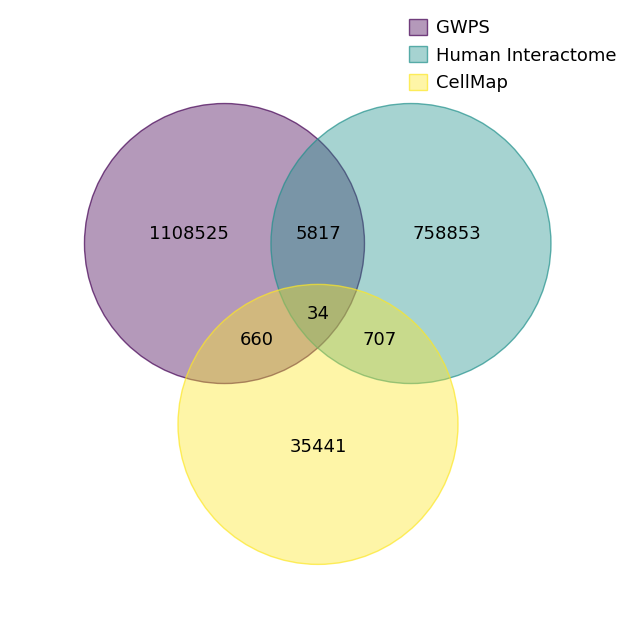

In [15]:
from venn import venn

# Create a dictionary of sets
sets = {
    #'OmniPath': omni,
    #'CollecTRI': collectri,
    "GWPS": gwps_s,
    "Human Interactome": humaninter_s,
    "CellMap": cellmap_s,
}

venn(sets)

In [15]:
sets = {
    "OmniPath": omni_s,
    "CollecTRI": collectri_s,
    "GWPS": gwps_s,
    "Human Interactome": humaninter_s,
    "CellMap": cellmap_s,
}

venn(sets)

NameError: name 'omni_s' is not defined

<Axes: >

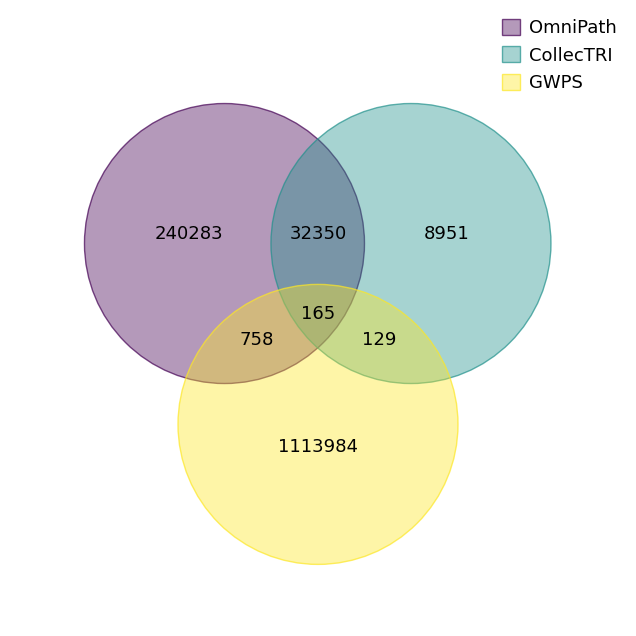

In [ ]:
sets = {
    "OmniPath": omni_s,
    "CollecTRI": collectri_s,
    "GWPS": gwps_s,
    #'Human Interactome': humaninter,
    #'CellMap': cellmap
}

venn(sets)

In [ ]:
del res

In [ ]:
# Load gene names
genes = load_genes("NCBITaxon:9606")

# Create empty anndata with gene names
empty_adata = ad.AnnData(X=np.zeros((1, len(genes))), var=genes)
print(f"Created empty AnnData with {len(genes)} genes")
empty_adata.var["ensembl_id"] = empty_adata.var.index
empty_adata.var.set_index("symbol", inplace=True, drop=False)
gt_cm = from_adata_and_longform(empty_adata, cellmap.iloc[:, [2, 4]])
gt_cm = gt_cm[:, (gt_cm.varp["GRN"].sum(1) != 0) | (gt_cm.varp["GRN"].sum(0) != 0)]
gt_cm.varp["GRN"] = scipy.sparse.csr_matrix(gt_cm.varp["GRN"].astype(np.float32))
gt_cm.varp["GRN"] = scipy.sparse.csr_matrix(gt_cm.varp["GRN"].astype(np.float32))

gt_inter = from_adata_and_longform(
    empty_adata,
    res[res["RF2-PPI_interaction_probability"] > THRESHOLD][
        ["geneA", "geneB", "RF2-PPI_interaction_probability"]
    ],
    has_weight=True,
)


gt_cm.var.index.name = "index"
gt_inter.var.index.name = "index"

In [ ]:
gt_cm.write_h5ad(LOC + "/gt_cellmap.h5ad")
gt_inter.write_h5ad(LOC + "/gt_humaninter.h5ad")

## Use scPRINT-2 to generate a gene network


In [ ]:
model_checkpoint_file = "../models/18hebyht-final-small.ckpt"
# "../models/ogvvg2z7-v1.ckpt"
# ""
# "../models/ji9krimq.ckpt"
# 18hebyht-final-small.ckpt"

In [50]:
model = scPRINT2.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [5]:
LOC = "/pasteur/appa/scratch/jkalfon/data/"

In [6]:
adata = sc.read(LOC + "/task4_human_preprocessed.h5ad")
# mouse = sc.read(LOC+"/task4_mouse_preprocessed.h5ad")

In [7]:
adata = adata[(adata.X.sum(1) > 500)]
adata = adata[
    adata.obs.celltype.isin(
        [k for k, v in adata.obs.celltype.value_counts().items() if v > 1000]
    )
]
adata.obs.celltype.value_counts()

celltype
Loop of Henle                  5985
Epithelial cell                3751
Intercalated cell              3416
Endothelial cell (APC)         2676
Monocyte                       2361
Macrophage                     2157
Smooth muscle cell             2156
Dendritic cell                 1828
Sinusoidal endothelial cell    1244
Name: count, dtype: int64

In [10]:
model.mask_zeros = True

In [ ]:
grn_inferer = GNInfer(
    how="most var within",  # most expr
    preprocess="softmax",
    head_agg="mean",
    filtration="none",
    num_genes=4000,
    max_cells=1024,
    num_workers=8,
    batch_size=16,
    precomp_attn=True,
    cell_type_col="celltype",
)
grn = grn_inferer(model, adata, cell_type=celltype)
grn.varp["GRN"][np.isnan(grn.varp["GRN"])] = 0
grn.var.index = make_index_unique(grn.var["symbol"].astype(str))

# run on multiple cell types in a dataset and test using our ground truths


In [ ]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name

In [ ]:
gt_cm = read_h5ad(LOC + "/gt_cellmap.h5ad")
gt_inter = read_h5ad(LOC + "/gt_humaninter.h5ad")

In [ ]:
gt_inter_high_qual = gt_inter.copy()
gt_inter_high_qual.varp["GRN"] = (gt_inter_high_qual.varp["GRN"] > 0.7).astype(
    np.float32
)

In [51]:
metrics = {}
shapes = []
for celltype in adata.obs.celltype.value_counts().keys().tolist():
    grn_inferer = GNInfer(
        how="most var within",  # most expr
        preprocess="softmax",
        head_agg="mean",
        filtration="none",
        num_genes=4000,
        max_cells=1024,
        num_workers=8,
        batch_size=16,
        precomp_attn=True,
        cell_type_col="celltype",
    )
    grn = grn_inferer(model, adata, cell_type=celltype)
    grn.varp["GRN"][np.isnan(grn.varp["GRN"])] = 0
    grn.var.index = make_index_unique(grn.var["symbol"].astype(str))
    metrics[celltype + "_collectri"] = BenGRN(grn).compare_to(to="collectri")
    metrics[celltype + "_omnipath"] = BenGRN(grn).compare_to(to="omnipath")
    metrics[celltype + "_cellmap"] = BenGRN(grn).compare_to(gt_cm)
    grn.varp["GRN"] = grn.varp["GRN"].T
    metrics[celltype + "_gwps"] = BenGRN(grn).compare_to(gwps)
    metrics[celltype + "_interact"] = BenGRN(grn).compare_to(gt_inter)
    metrics[celltype + "_interact_hq"] = BenGRN(grn).compare_to(gt_inter_high_qual)
    del grn
# grn.varp["all"] = grn.varp["GRN"]
# grn.varp["GRN"] = grn.varp["GRN"][:, :, :].mean(-1)
# metrics[celltype + "_scprint_mean"] = BenGRN(grn).scprint_benchmark()

number of expressed genes in this cell type: 15492


ValueError: neighbors key not found in adata.obsm

## gathering multiple scores


In [16]:
# most var across, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 4.320847454189799 0.001650089507826676
omnipath 2.161961011485835 0.0022005348151650124
cellmap 0.7579036152773526 0.00279858487990163
gwps 4.393426476008669 0.05303653714649336
interact 0.7885126112275245 0.0032431919506751674
interact 1.3165039188215408 0.0007380336918651627


In [ ]:
# no zero expr most var across, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.946032355129409 0.002094824186664233
omnipath 2.7240708744721527 0.002766940004414173
cellmap 0.5052690768515684 0.0028969264816182203
gwps 6.255797196027438 0.07189889987374425
interact 2.3880667654319314 0.003625986726765378
interact 9.654362071357966 0.0010260613477399562


In [ ]:
# no zero expr second trial, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.391822622152974 0.0026499323091102815
omnipath 11.786240962326248 0.002825303653759943
cellmap 1.5208244405146656 0.0029901568828903415
gwps 1.9368401547916452 0.02477496894268167
interact 1.3093877841006418 0.003950697092027391
interact 11.32344314936535 0.0005978302259696873


In [ ]:
# no zero expr, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.015833056143975 0.002604055862554985
omnipath 11.092932670424705 0.002789710383641038
cellmap 1.6898049339051837 0.0030508892757604446
gwps 3.365786084209938 0.03307093983753216
interact 1.3778525048379302 0.004175442762947657
interact 15.31995249620018 0.0006296682248338563


In [ ]:
# max most var within, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.4223730795878544 0.0017729955048933004
omnipath 1.314072511477024 0.002161736784490282
cellmap 1.0378315416535224 0.0025352133717579115
gwps 3.2769448126414873 0.05856635319675267
interact 1.5962985773386713 0.0038399127586959555
interact 2.567721870436926 0.0008905285981570997


In [ ]:
# mean full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.7678121881619715 0.002635528851595563
omnipath 12.01734372629343 0.0028207894582880063
cellmap 1.5208244405146656 0.0030141050792928887
gwps 3.3460492619804034 0.032997567275140895
interact 1.3607363246536082 0.004176705484362731
interact 15.31995249620018 0.0006371698945342159


In [ ]:
# less cells
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 1.695661155711498 0.00181250742174925
omnipath 1.415155012359872 0.0023906906948043326
cellmap 1.0378315416535224 0.0026622182250509623
gwps 5.032339607614996 0.07293228734948903
interact 2.7441986778968173 0.004182887096974328
interact 3.2096523380461575 0.001013204125433611


In [ ]:
# more genes
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 0.7795931067176785 0.001626955095128026
omnipath 1.4136550849371263 0.0021280710909285278
cellmap 0.9890787726587984 0.0025631016217331727
gwps 5.039374243159614 0.060350320698679814
interact 2.1219004919374047 0.003919617245090371
interact 5.927645002142037 0.0008990599629006808


In [ ]:
# most expr
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 0.9918788577397826 0.002050403690883833
omnipath 1.1160264447330215 0.003021266229591356
cellmap 1.4443264095621609 0.0027797259350693768
gwps 2.7120910456155856 0.06918387763206227
interact 1.5280781386541193 0.004826298411995087
interact 1.9205865623689202 0.0012705638404502053


In [ ]:
interact best #(most expr AUPRC) # (mean full #EPR)
interact #(most expr) # (most var across)
gwps # (most var across)
cellmap #(most var within) # (mean full)
omnipath # (mean full)
collectri #(mean full)

In [ ]:
# within
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.89554375 0.0023501150639435595
omnipath 5.016505190311419 0.002239796342907146
cellmap 2.4469455895622545 0.002954973537836676
gwps 3.219736432055241 0.032151210471834335
interact 1.286258947175577 0.003832185953245134
interact 0.0 0.0005739554645104968


In [ ]:
# across
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 1.2111865397939272 0.0018516594378383262
omnipath 1.364613761918448 0.002451264598245648
cellmap 1.383775388871363 0.0026919804270312195
gwps 4.8764430894113096 0.06884667790676557
interact 2.3496080183299544 0.004083259545637848
interact 5.135443740873852 0.0009764047028928342


In [ ]:
metrics_v1 = {
    "Loop of Henle_collectri": {
        "precision": 0.0016351735562295604,
        "rand_precision": 0.0016360646589849987,
        "auprc": 0.002501024287817965,
        "ap": 0.0025052068378218248,
        "epr": 1.774231601298447,
        "odd_ratio": 1.7787460617116801,
    },
    "Loop of Henle_omnipath": {
        "precision": 0.001963606529092425,
        "rand_precision": 0.001964338671720722,
        "auprc": 0.003089559023179079,
        "ap": 0.003094483024053828,
        "epr": 1.872798980071019,
        "odd_ratio": 1.8792563169522223,
    },
    "Loop of Henle_cellmap": {
        "precision": 0.002768556216724084,
        "rand_precision": 0.0027703435351338476,
        "auprc": 0.002832137484865851,
        "ap": 0.002893705694786363,
        "epr": 1.2249979525398744,
        "odd_ratio": 1.2265328971695306,
    },
    "Loop of Henle_gwps": {
        "precision": 0.01769601420573712,
        "rand_precision": 0.01770759536686653,
        "auprc": 0.03931138205956882,
        "ap": 0.041163393033549524,
        "epr": 3.930948408742879,
        "odd_ratio": 4.385913870846728,
    },
    "Loop of Henle_interact": {
        "precision": 0.002988486995568852,
        "rand_precision": 0.00298950626125629,
        "auprc": 0.0035740191356482248,
        "ap": 0.003578799193481954,
        "epr": 2.798147255991484,
        "odd_ratio": 2.828612270953828,
    },
    "Loop of Henle_interact_hq": {
        "precision": 0.0005347732521561882,
        "rand_precision": 0.0005349556441248636,
        "auprc": 0.0008291974093972697,
        "ap": 0.0008298397382536897,
        "epr": 7.243242974318198,
        "odd_ratio": 7.291908452744588,
    },
    "Epithelial cell_collectri": {
        "precision": 0.0014307207836572373,
        "rand_precision": 0.0014315147463562702,
        "auprc": 0.002222724029474912,
        "ap": 0.002237226521176974,
        "epr": 2.7035246857161823,
        "odd_ratio": 2.716787371109826,
    },
    "Epithelial cell_omnipath": {
        "precision": 0.0015545019752171024,
        "rand_precision": 0.0015550850592288116,
        "auprc": 0.002508869850817089,
        "ap": 0.0025136519921734385,
        "epr": 2.0936835573651753,
        "odd_ratio": 2.1008402424581605,
    },
    "Epithelial cell_cellmap": {
        "precision": 0.0025700488783087618,
        "rand_precision": 0.0025714878754410737,
        "auprc": 0.0025860332230780705,
        "ap": 0.0025966506823457505,
        "epr": 1.3563325570269875,
        "odd_ratio": 1.35883125,
    },
    "Epithelial cell_gwps": {
        "precision": 0.020576408515634702,
        "rand_precision": 0.02058742962357023,
        "auprc": 0.03852224643061224,
        "ap": 0.03977372329288779,
        "epr": 3.4979993031122327,
        "odd_ratio": 3.9007495036136106,
    },
    "Epithelial cell_interact": {
        "precision": 0.003325516866811766,
        "rand_precision": 0.0033266205896351356,
        "auprc": 0.00376181621917231,
        "ap": 0.0037774050966210004,
        "epr": 2.360328143865214,
        "odd_ratio": 2.3819447724913605,
    },
    "Epithelial cell_interact_hq": {
        "precision": 0.0005029854669496383,
        "rand_precision": 0.0005031524053721241,
        "auprc": 0.0007432074289854531,
        "ap": 0.0007550450546496432,
        "epr": 9.452886476520648,
        "odd_ratio": 9.533871752818067,
    },
    "Intercalated cell_collectri": {
        "precision": 0.0016556420841934072,
        "rand_precision": 0.0016565876250752994,
        "auprc": 0.002592782157361332,
        "ap": 0.002599925773062286,
        "epr": 1.3066028815733657,
        "odd_ratio": 1.307934488613104,
    },
    "Intercalated cell_omnipath": {
        "precision": 0.0017150386922127202,
        "rand_precision": 0.0017156803078850781,
        "auprc": 0.0028015218921272618,
        "ap": 0.002802831091185767,
        "epr": 1.9011960200947766,
        "odd_ratio": 1.9071040335818337,
    },
    "Intercalated cell_cellmap": {
        "precision": 0.0022007547734210786,
        "rand_precision": 0.0022020663078510076,
        "auprc": 0.00218205597766263,
        "ap": 0.002197481269201786,
        "epr": 0.5511152087849939,
        "odd_ratio": 0.5500236960177403,
    },
    "Intercalated cell_gwps": {
        "precision": 0.021055155319672985,
        "rand_precision": 0.021066944320411885,
        "auprc": 0.044367317258721325,
        "ap": 0.045368043625614876,
        "epr": 3.805185380247522,
        "odd_ratio": 4.315434181013659,
    },
    "Intercalated cell_interact": {
        "precision": 0.0033202743561688963,
        "rand_precision": 0.0033214075556078615,
        "auprc": 0.003836522817276675,
        "ap": 0.0038568003464906028,
        "epr": 2.6990477280317364,
        "odd_ratio": 2.7299250042723058,
    },
    "Intercalated cell_interact_hq": {
        "precision": 0.000577479560761717,
        "rand_precision": 0.000577676652761977,
        "auprc": 0.0008630355797273662,
        "ap": 0.000871223401494808,
        "epr": 8.99627242648995,
        "odd_ratio": 9.080037079571015,
    },
    "Endothelial cell (APC)_collectri": {
        "precision": 0.001200845478618044,
        "rand_precision": 0.0012015312841455242,
        "auprc": 0.0018456758693261121,
        "ap": 0.0018450135281207851,
        "epr": 1.3547552308171964,
        "odd_ratio": 1.3559129844045368,
    },
    "Endothelial cell (APC)_omnipath": {
        "precision": 0.0014393562374743463,
        "rand_precision": 0.001439881549969775,
        "auprc": 0.002276469359825681,
        "ap": 0.0022761081573660614,
        "epr": 2.2477857426732686,
        "odd_ratio": 2.255902155046973,
    },
    "Endothelial cell (APC)_cellmap": {
        "precision": 0.0024410482902542468,
        "rand_precision": 0.0024424021717241603,
        "auprc": 0.00249353527335202,
        "ap": 0.002507143116804185,
        "epr": 2.0745107241492637,
        "odd_ratio": 2.08548268175583,
    },
    "Endothelial cell (APC)_gwps": {
        "precision": 0.02184326416342992,
        "rand_precision": 0.02185454684120029,
        "auprc": 0.04377246518181342,
        "ap": 0.04594163705274328,
        "epr": 3.801445802812914,
        "odd_ratio": 4.332101853299244,
    },
    "Endothelial cell (APC)_interact": {
        "precision": 0.003367953925015091,
        "rand_precision": 0.003369066930277819,
        "auprc": 0.0037719648225747965,
        "ap": 0.003787886448380204,
        "epr": 2.2724588494065783,
        "odd_ratio": 2.292168970209985,
    },
    "Endothelial cell (APC)_interact_hq": {
        "precision": 0.0005464326552273234,
        "rand_precision": 0.0005466132344260104,
        "auprc": 0.000709931619135055,
        "ap": 0.0007213409022709268,
        "epr": 7.879180000326058,
        "odd_ratio": 7.938820404102992,
    },
    "Monocyte_collectri": {
        "precision": 0.0016847018347605363,
        "rand_precision": 0.0016856870405118584,
        "auprc": 0.0027055378996639094,
        "ap": 0.002715114095030862,
        "epr": 3.247609089456018,
        "odd_ratio": 3.272421513340628,
    },
    "Monocyte_omnipath": {
        "precision": 0.0016860794417895132,
        "rand_precision": 0.00168670951631933,
        "auprc": 0.002851691508934519,
        "ap": 0.0028603980179683257,
        "epr": 5.053847745375651,
        "odd_ratio": 5.123854636692763,
    },
    "Monocyte_cellmap": {
        "precision": 0.00243065695919019,
        "rand_precision": 0.002432002837905135,
        "auprc": 0.0024335701470472922,
        "ap": 0.002503028590822885,
        "epr": 1.5378540653213184,
        "odd_ratio": 1.5418999678716523,
    },
    "Monocyte_gwps": {
        "precision": 0.027794338292417717,
        "rand_precision": 0.02780808425596491,
        "auprc": 0.05084426840394064,
        "ap": 0.05285314850254981,
        "epr": 3.446004963094797,
        "odd_ratio": 3.9919481975819466,
    },
    "Monocyte_interact": {
        "precision": 0.0037083348454805495,
        "rand_precision": 0.0037095591224186415,
        "auprc": 0.004199570581257989,
        "ap": 0.00423747843446854,
        "epr": 2.2704318833910975,
        "odd_ratio": 2.2921052267760365,
    },
    "Monocyte_interact_hq": {
        "precision": 0.000681921525485882,
        "rand_precision": 0.0006821466563955834,
        "auprc": 0.0009090961596790301,
        "ap": 0.0009637160308985133,
        "epr": 11.036484137634218,
        "odd_ratio": 11.18932734075388,
    },
    "Macrophage_collectri": {
        "precision": 0.001525422824805722,
        "rand_precision": 0.0015263040627172214,
        "auprc": 0.002407516313008484,
        "ap": 0.002424732647266113,
        "epr": 2.8635377952467116,
        "odd_ratio": 2.879934881189775,
    },
    "Macrophage_omnipath": {
        "precision": 0.0016541599379445494,
        "rand_precision": 0.0016547829737027205,
        "auprc": 0.0027926793403765934,
        "ap": 0.0027943066180829107,
        "epr": 4.143003530826712,
        "odd_ratio": 4.186546224914573,
    },
    "Macrophage_cellmap": {
        "precision": 0.002460724720713958,
        "rand_precision": 0.00246215371300241,
        "auprc": 0.0024978322783110116,
        "ap": 0.0025422744696205106,
        "epr": 1.0256274869911235,
        "odd_ratio": 1.0257574106713667,
    },
    "Macrophage_gwps": {
        "precision": 0.02257643062451006,
        "rand_precision": 0.022589121142005567,
        "auprc": 0.037755352277540025,
        "ap": 0.038820887047525614,
        "epr": 3.2146712403311235,
        "odd_ratio": 3.575079422907708,
    },
    "Macrophage_interact": {
        "precision": 0.003513577168753223,
        "rand_precision": 0.003514752278174211,
        "auprc": 0.003858058239635541,
        "ap": 0.0038708651958536365,
        "epr": 1.8907387091723038,
        "odd_ratio": 1.9026965443311548,
    },
    "Macrophage_interact_hq": {
        "precision": 0.0006291519485994214,
        "rand_precision": 0.0006293623673113276,
        "auprc": 0.0007270419610041921,
        "ap": 0.0007294694414440774,
        "epr": 3.441681763088272,
        "odd_ratio": 3.4522939132656587,
    },
    "Smooth muscle cell_collectri": {
        "precision": 0.0015214809524205,
        "rand_precision": 0.001522358392416129,
        "auprc": 0.0024352013065892407,
        "ap": 0.002452439127830983,
        "epr": 3.2987199900840944,
        "odd_ratio": 3.3219826556062193,
    },
    "Smooth muscle cell_omnipath": {
        "precision": 0.0019526530612244898,
        "rand_precision": 0.001953397212543554,
        "auprc": 0.0029418679729150427,
        "ap": 0.002941384775408097,
        "epr": 3.462319379143576,
        "odd_ratio": 3.4959670821313313,
    },
    "Smooth muscle cell_cellmap": {
        "precision": 0.002630950135194617,
        "rand_precision": 0.0026325227294176864,
        "auprc": 0.0028085359261413086,
        "ap": 0.002830400787936774,
        "epr": 1.6342131455896816,
        "odd_ratio": 1.6397054637719473,
    },
    "Smooth muscle cell_gwps": {
        "precision": 0.02033723565503044,
        "rand_precision": 0.020349487001810582,
        "auprc": 0.03470059891919177,
        "ap": 0.03605819921456768,
        "epr": 3.3089231911661696,
        "odd_ratio": 3.6543489993759946,
    },
    "Smooth muscle cell_interact": {
        "precision": 0.0032318697180226475,
        "rand_precision": 0.0032329761438076605,
        "auprc": 0.0037180167679680626,
        "ap": 0.0037687775741136586,
        "epr": 2.4438166884012067,
        "odd_ratio": 2.4669045625465555,
    },
    "Smooth muscle cell_interact_hq": {
        "precision": 0.000547190603250755,
        "rand_precision": 0.0005473779331388929,
        "auprc": 0.0007418425977381517,
        "ap": 0.0008776930318661791,
        "epr": 8.976055665074009,
        "odd_ratio": 9.055014535294475,
    },
    "Dendritic cell_collectri": {
        "precision": 0.001863522261857577,
        "rand_precision": 0.0018645938675285704,
        "auprc": 0.0027259047673809404,
        "ap": 0.0027314137898254544,
        "epr": 1.9961903940932197,
        "odd_ratio": 2.0036478133170332,
    },
    "Dendritic cell_omnipath": {
        "precision": 0.0017944319338525608,
        "rand_precision": 0.0017951121582399196,
        "auprc": 0.002798594452030419,
        "ap": 0.0028004763985389814,
        "epr": 3.6106688618791756,
        "odd_ratio": 3.644843146200197,
    },
    "Dendritic cell_cellmap": {
        "precision": 0.0025644517066085695,
        "rand_precision": 0.0025660240252514933,
        "auprc": 0.0025314380326634015,
        "ap": 0.0025608717435735653,
        "epr": 0.8114689528407494,
        "odd_ratio": 0.8106813566341732,
    },
    "Dendritic cell_gwps": {
        "precision": 0.020591396571621734,
        "rand_precision": 0.020603552059562477,
        "auprc": 0.03864175414963547,
        "ap": 0.03999370373757901,
        "epr": 3.4559598150887267,
        "odd_ratio": 3.8469613010301305,
    },
    "Dendritic cell_interact": {
        "precision": 0.003302037721925473,
        "rand_precision": 0.003303175178943015,
        "auprc": 0.0036112244642770284,
        "ap": 0.0036262598227583933,
        "epr": 1.9380935049311543,
        "odd_ratio": 1.9502209284176317,
    },
    "Dendritic cell_interact_hq": {
        "precision": 0.0005689515475611732,
        "rand_precision": 0.0005691475350043566,
        "auprc": 0.0006875793699458869,
        "ap": 0.0006959668442221671,
        "epr": 5.504742348193061,
        "odd_ratio": 5.533102367346939,
    },
    "Sinusoidal endothelial cell_collectri": {
        "precision": 0.0011663718726676602,
        "rand_precision": 0.0011670711363802905,
        "auprc": 0.0018216943896828925,
        "ap": 0.001821697893649995,
        "epr": 2.373534068441259,
        "odd_ratio": 2.3811754115226336,
    },
    "Sinusoidal endothelial cell_omnipath": {
        "precision": 0.0015512639937125918,
        "rand_precision": 0.0015518634002016616,
        "auprc": 0.002382655775429879,
        "ap": 0.002385135497641302,
        "epr": 3.0986084478272544,
        "odd_ratio": 3.118937772625131,
    },
    "Sinusoidal endothelial cell_cellmap": {
        "precision": 0.0025586115193505492,
        "rand_precision": 0.002560163133370774,
        "auprc": 0.0025710453750921,
        "ap": 0.0025806307361208123,
        "epr": 1.7094096691868288,
        "odd_ratio": 1.7156599444511533,
    },
    "Sinusoidal endothelial cell_gwps": {
        "precision": 0.021321176929374845,
        "rand_precision": 0.021333416410964614,
        "auprc": 0.02788843442348146,
        "ap": 0.028375431250626994,
        "epr": 2.454220051678204,
        "odd_ratio": 2.6193492244310512,
    },
    "Sinusoidal endothelial cell_interact": {
        "precision": 0.0033618192206767007,
        "rand_precision": 0.0033629697406016416,
        "auprc": 0.003756156180402775,
        "ap": 0.003760701507275269,
        "epr": 1.6201566184222929,
        "odd_ratio": 1.6269701467749818,
    },
    "Sinusoidal endothelial cell_interact_hq": {
        "precision": 0.0005267574511549654,
        "rand_precision": 0.0005269377240677494,
        "auprc": 0.0006514168870591008,
        "ap": 0.0006574398220037912,
        "epr": 5.152282713294158,
        "odd_ratio": 5.17492119591174,
    },
}

In [7]:
# scPRINT-V1
metrics_v1 = {
    "Loop of Henle_collectri": {
        "rand_precision": 0.0016360646589849987,
        "auprc": 0.0022197900302843732,
        "ap": 0.0022256980810455725,
        "epr": 0.3326684252434588,
        "odd_ratio": 0.3319414185885892,
    },
    "Loop of Henle_omnipath": {
        "rand_precision": 0.001964338671720722,
        "auprc": 0.002999505803702939,
        "ap": 0.003003267941393817,
        "epr": 1.0084302200382411,
        "odd_ratio": 1.0084637183606127,
    },
    "Loop of Henle_cellmap": {
        "rand_precision": 0.0027703435351338476,
        "auprc": 0.00299428343667702,
        "ap": 0.002998483556081243,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Loop of Henle_gwps": {
        "rand_precision": 0.0027703435351338476,
        "auprc": 0.00299428343667702,
        "ap": 0.002998483556081243,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Loop of Henle_interact": {
        "rand_precision": 0.00298950626125629,
        "auprc": 0.0035738090156042885,
        "ap": 0.0035781896041834228,
        "epr": 2.7850104144140593,
        "odd_ratio": 2.815109085267852,
    },
    "Loop of Henle_interact_hq": {
        "rand_precision": 0.0005349556441248636,
        "auprc": 0.0008289610125244967,
        "ap": 0.0008293163777116502,
        "epr": 7.243242974318198,
        "odd_ratio": 7.291908452744588,
    },
    "Epithelial cell_collectri": {
        "rand_precision": 0.0014315147463562702,
        "auprc": 0.0018889158318145657,
        "ap": 0.0018912488079074969,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Epithelial cell_omnipath": {
        "rand_precision": 0.0015550850592288116,
        "auprc": 0.002529945576219922,
        "ap": 0.002536731886220471,
        "epr": 1.1631575318695417,
        "odd_ratio": 1.1637493787832305,
    },
    "Epithelial cell_cellmap": {
        "rand_precision": 0.0025714878754410737,
        "auprc": 0.002938111306394351,
        "ap": 0.0029517818138190786,
        "epr": 0.5812853815829946,
        "odd_ratio": 0.5800308066501727,
    },
    "Epithelial cell_gwps": {
        "rand_precision": 0.0025714878754410737,
        "auprc": 0.002938111306394351,
        "ap": 0.0029517818138190786,
        "epr": 0.5812853815829946,
        "odd_ratio": 0.5800308066501727,
    },
    "Epithelial cell_interact": {
        "rand_precision": 0.0033266205896351356,
        "auprc": 0.0037613901295581956,
        "ap": 0.003777126860922326,
        "epr": 2.3703720934135766,
        "odd_ratio": 2.3922420989296693,
    },
    "Epithelial cell_interact_hq": {
        "rand_precision": 0.0005031524053721241,
        "auprc": 0.0007429638483895612,
        "ap": 0.00075507091505666,
        "epr": 9.452886476520648,
        "odd_ratio": 9.533871752818067,
    },
    "Intercalated cell_collectri": {
        "rand_precision": 0.0016565876250752994,
        "auprc": 0.002242334731636479,
        "ap": 0.002245131342712549,
        "epr": 0.47512832057213295,
        "odd_ratio": 0.47430109977148915,
    },
    "Intercalated cell_omnipath": {
        "rand_precision": 0.0017156803078850781,
        "auprc": 0.0028035382304503337,
        "ap": 0.002805581270491533,
        "epr": 1.283307313563974,
        "odd_ratio": 1.2845589868149345,
    },
    "Intercalated cell_cellmap": {
        "rand_precision": 0.0022020663078510076,
        "auprc": 0.0024536909920569697,
        "ap": 0.0024599799741398865,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Intercalated cell_gwps": {
        "rand_precision": 0.0022020663078510076,
        "auprc": 0.0024536909920569697,
        "ap": 0.0024599799741398865,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Intercalated cell_interact": {
        "rand_precision": 0.0033214075556078615,
        "auprc": 0.0038363061191326858,
        "ap": 0.003856707322822372,
        "epr": 2.7097159008698064,
        "odd_ratio": 2.740911539266517,
    },
    "Intercalated cell_interact_hq": {
        "rand_precision": 0.000577676652761977,
        "auprc": 0.0008631113501905528,
        "ap": 0.0008716646336338009,
        "epr": 8.99627242648995,
        "odd_ratio": 9.080037079571015,
    },
    "Endothelial cell (APC)_collectri": {
        "rand_precision": 0.0012015312841455242,
        "auprc": 0.0017865491439520076,
        "ap": 0.0017966800025785259,
        "epr": 0.22579253846953276,
        "odd_ratio": 0.22537228744644852,
    },
    "Endothelial cell (APC)_omnipath": {
        "rand_precision": 0.001439881549969775,
        "auprc": 0.0023910141635906006,
        "ap": 0.002399625222260653,
        "epr": 1.9266734937199443,
        "odd_ratio": 1.931836489546003,
    },
    "Endothelial cell (APC)_cellmap": {
        "rand_precision": 0.0024424021717241603,
        "auprc": 0.0027382348650563898,
        "ap": 0.0027453811374845293,
        "epr": 0.5657756520407083,
        "odd_ratio": 0.5645730926866465,
    },
    "Endothelial cell (APC)_gwps": {
        "rand_precision": 0.0024424021717241603,
        "auprc": 0.0027382348650563898,
        "ap": 0.0027453811374845293,
        "epr": 0.5657756520407083,
        "odd_ratio": 0.5645730926866465,
    },
    "Endothelial cell (APC)_interact": {
        "rand_precision": 0.003369066930277819,
        "auprc": 0.003765486763053893,
        "ap": 0.003781589580348783,
        "epr": 2.2724588494065783,
        "odd_ratio": 2.292168970209985,
    },
    "Endothelial cell (APC)_interact_hq": {
        "rand_precision": 0.0005466132344260104,
        "auprc": 0.0007089164672483043,
        "ap": 0.0007198767218621724,
        "epr": 8.371628750346439,
        "odd_ratio": 8.439560462864028,
    },
    "Monocyte_collectri": {
        "rand_precision": 0.0016856870405118584,
        "auprc": 0.0020307934682426572,
        "ap": 0.002051908737089973,
        "epr": 0.8419727268960046,
        "odd_ratio": 0.8415231930737715,
    },
    "Monocyte_omnipath": {
        "rand_precision": 0.00168670951631933,
        "auprc": 0.002790592528548713,
        "ap": 0.002813753233971633,
        "epr": 3.5327867734664746,
        "odd_ratio": 3.563243392998596,
    },
    "Monocyte_cellmap": {
        "rand_precision": 0.002432002837905135,
        "auprc": 0.0026958545667712603,
        "ap": 0.0026998406705982005,
        "epr": 1.1533905489909888,
        "odd_ratio": 1.154254719388512,
    },
    "Monocyte_gwps": {
        "rand_precision": 0.002432002837905135,
        "auprc": 0.0026958545667712603,
        "ap": 0.0026998406705982005,
        "epr": 1.1533905489909888,
        "odd_ratio": 1.154254719388512,
    },
    "Monocyte_interact": {
        "rand_precision": 0.0037095591224186415,
        "auprc": 0.004199170086279234,
        "ap": 0.004236307950886452,
        "epr": 2.246448448003163,
        "odd_ratio": 2.2674851812192327,
    },
    "Monocyte_interact_hq": {
        "rand_precision": 0.0006821466563955834,
        "auprc": 0.0009095565037949163,
        "ap": 0.0009629662739041072,
        "epr": 11.036484137634218,
        "odd_ratio": 11.18932734075388,
    },
    "Macrophage_collectri": {
        "rand_precision": 0.0015263040627172214,
        "auprc": 0.0021029682629947477,
        "ap": 0.0021100277651139635,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Macrophage_omnipath": {
        "rand_precision": 0.0016547829737027205,
        "auprc": 0.002823607533856724,
        "ap": 0.002827658142593077,
        "epr": 2.3822270302253594,
        "odd_ratio": 2.3931894775382876,
    },
    "Macrophage_cellmap": {
        "rand_precision": 0.00246215371300241,
        "auprc": 0.0028222143569289577,
        "ap": 0.0029117001517864807,
        "epr": 1.4358784817875727,
        "odd_ratio": 1.4389768720093281,
    },
    "Macrophage_gwps": {
        "rand_precision": 0.00246215371300241,
        "auprc": 0.0028222143569289577,
        "ap": 0.0029117001517864807,
        "epr": 1.4358784817875727,
        "odd_ratio": 1.4389768720093281,
    },
    "Macrophage_interact": {
        "rand_precision": 0.003514752278174211,
        "auprc": 0.0038577522992340094,
        "ap": 0.0038708313788098636,
        "epr": 1.8816047057463505,
        "odd_ratio": 1.893382173780915,
    },
    "Macrophage_interact_hq": {
        "rand_precision": 0.0006293623673113276,
        "auprc": 0.0007265329764612701,
        "ap": 0.0007294334219004334,
        "epr": 3.441681763088272,
        "odd_ratio": 3.4522939132656587,
    },
    "Smooth muscle cell_collectri": {
        "rand_precision": 0.001522358392416129,
        "auprc": 0.002233304005423953,
        "ap": 0.0022415336324816742,
        "epr": 2.438184340496939,
        "odd_ratio": 2.448920556963511,
    },
    "Smooth muscle cell_omnipath": {
        "rand_precision": 0.001953397212543554,
        "auprc": 0.003033932343429758,
        "ap": 0.003036832567610206,
        "epr": 4.261316158945939,
        "odd_ratio": 4.316296361522517,
    },
    "Smooth muscle cell_cellmap": {
        "rand_precision": 0.0026325227294176864,
        "auprc": 0.0032564781314774697,
        "ap": 0.003261316866901108,
        "epr": 3.63158476797707,
        "odd_ratio": 3.6826327499590046,
    },
    "Smooth muscle cell_gwps": {
        "rand_precision": 0.0026325227294176864,
        "auprc": 0.0032564781314774697,
        "ap": 0.003261316866901108,
        "epr": 3.63158476797707,
        "odd_ratio": 3.6826327499590046,
    },
    "Smooth muscle cell_interact": {
        "rand_precision": 0.0032329761438076605,
        "auprc": 0.003718839125484954,
        "ap": 0.003769170547690047,
        "epr": 2.4551306545512124,
        "odd_ratio": 2.4785084692517327,
    },
    "Smooth muscle cell_interact_hq": {
        "rand_precision": 0.0005473779331388929,
        "auprc": 0.0007419965905188435,
        "ap": 0.0008774239534851701,
        "epr": 8.976055665074009,
        "odd_ratio": 9.055014535294475,
    },
    "Dendritic cell_collectri": {
        "rand_precision": 0.0018645938675285704,
        "auprc": 0.002248474924593263,
        "ap": 0.0022541675147945395,
        "epr": 0.09505668543301046,
        "odd_ratio": 0.09473581199715998,
    },
    "Dendritic cell_omnipath": {
        "rand_precision": 0.0017951121582399196,
        "auprc": 0.0026522662034466245,
        "ap": 0.0026569161960756267,
        "epr": 1.6047417163907447,
        "odd_ratio": 1.6082409780420055,
    },
    "Dendritic cell_cellmap": {
        "rand_precision": 0.0025660240252514933,
        "auprc": 0.003071815327963443,
        "ap": 0.0030789636505841236,
        "epr": 0.4057344764203747,
        "odd_ratio": 0.4044951325992971,
    },
    "Dendritic cell_gwps": {
        "rand_precision": 0.0025660240252514933,
        "auprc": 0.003071815327963443,
        "ap": 0.0030789636505841236,
        "epr": 0.4057344764203747,
        "odd_ratio": 0.4044951325992971,
    },
    "Dendritic cell_interact": {
        "rand_precision": 0.003303175178943015,
        "auprc": 0.003611360297909579,
        "ap": 0.0036260942204121883,
        "epr": 1.9270816100167727,
        "odd_ratio": 1.9389979226312095,
    },
    "Dendritic cell_interact_hq": {
        "rand_precision": 0.0005691475350043566,
        "auprc": 0.0006876530203248743,
        "ap": 0.0006958272723041252,
        "epr": 5.504742348193061,
        "odd_ratio": 5.533102367346939,
    },
    "Sinusoidal endothelial cell_collectri": {
        "rand_precision": 0.0011670711363802905,
        "auprc": 0.0016234416698115465,
        "ap": 0.001621648471501718,
        "epr": 2.9009860836504284,
        "odd_ratio": 2.9139239253140117,
    },
    "Sinusoidal endothelial cell_omnipath": {
        "rand_precision": 0.0015518634002016616,
        "auprc": 0.002652354098977331,
        "ap": 0.002664625931944679,
        "epr": 5.205662192349787,
        "odd_ratio": 5.274445246485486,
    },
    "Sinusoidal endothelial cell_cellmap": {
        "rand_precision": 0.002560163133370774,
        "auprc": 0.0028424013691192504,
        "ap": 0.002857561452652857,
        "epr": 0.6410286259450608,
        "odd_ratio": 0.6398474760743104,
    },
    "Sinusoidal endothelial cell_gwps": {
        "rand_precision": 0.002560163133370774,
        "auprc": 0.0028424013691192504,
        "ap": 0.002857561452652857,
        "epr": 0.6410286259450608,
        "odd_ratio": 0.6398474760743104,
    },
    "Sinusoidal endothelial cell_interact": {
        "rand_precision": 0.0033629697406016416,
        "auprc": 0.0037560807680880864,
        "ap": 0.003760139750265865,
        "epr": 1.6201566184222929,
        "odd_ratio": 1.6269701467749818,
    },
    "Sinusoidal endothelial cell_interact_hq": {
        "rand_precision": 0.0005269377240677494,
        "auprc": 0.0006512398985005839,
        "ap": 0.0006571722354555803,
        "epr": 5.152282713294158,
        "odd_ratio": 5.17492119591174,
    },
}

In [ ]:
metrics_v2 = {
    "Loop of Henle_collectri": {
        "rand_precision": 0.0016359932992993681,
        "auprc": 0.002282662116444059,
        "ap": 0.0022636083902423357,
        "epr": 3.4909235200106004,
        "odd_ratio": 3.5196210921397633,
    },
    "Loop of Henle_omnipath": {
        "rand_precision": 0.0019456495169911713,
        "auprc": 0.0025424094236147898,
        "ap": 0.0025309289314268553,
        "epr": 4.606905494127075,
        "odd_ratio": 4.672445812790847,
    },
    "Loop of Henle_cellmap": {
        "rand_precision": 0.002762858587135094,
        "auprc": 0.002910773015478242,
        "ap": 0.0028734215469562218,
        "epr": 2.0694337791978494,
        "odd_ratio": 2.0817685535730877,
    },
    "Loop of Henle_gwps": {
        "rand_precision": 0.017565207265952492,
        "auprc": 0.043945148073361515,
        "ap": 0.04660718289243268,
        "epr": 5.083100525593068,
        "odd_ratio": 5.922953959346351,
    },
    "Loop of Henle_interact": {
        "rand_precision": 0.0029842561668897995,
        "auprc": 0.003151896793700687,
        "ap": 0.00317994310590997,
        "epr": 2.1296802501654257,
        "odd_ratio": 2.1441777028526037,
    },
    "Loop of Henle_interact_hq": {
        "rand_precision": 0.0005284844575252994,
        "auprc": 0.000739821068978216,
        "ap": 0.0007987103469400719,
        "epr": 18.477419441351017,
        "odd_ratio": 18.82382007640058,
    },
    "Epithelial cell_collectri": {
        "rand_precision": 0.0014392279852820232,
        "auprc": 0.0020763286169975673,
        "ap": 0.002095233805878384,
        "epr": 3.946098889574066,
        "odd_ratio": 3.9798499124354074,
    },
    "Epithelial cell_omnipath": {
        "rand_precision": 0.0015432451033319371,
        "auprc": 0.0021542509409351977,
        "ap": 0.0022224151936037447,
        "epr": 3.654164529588358,
        "odd_ratio": 3.684354774233441,
    },
    "Epithelial cell_cellmap": {
        "rand_precision": 0.002557244744744745,
        "auprc": 0.0025522149153714407,
        "ap": 0.0026175593824335234,
        "epr": 1.7937884016496928,
        "odd_ratio": 1.8011212809785724,
    },
    "Epithelial cell_gwps": {
        "rand_precision": 0.02049057675736326,
        "auprc": 0.035173815210138897,
        "ap": 0.037285639545023036,
        "epr": 3.7121220355560283,
        "odd_ratio": 4.177056944982221,
    },
    "Epithelial cell_interact": {
        "rand_precision": 0.0033225144336255447,
        "auprc": 0.0033792674698514616,
        "ap": 0.003354588614012338,
        "epr": 1.9743529142428695,
        "odd_ratio": 1.987262957949657,
    },
    "Epithelial cell_interact_hq": {
        "rand_precision": 0.0004966417664830364,
        "auprc": 0.0006963549377337196,
        "ap": 0.0007864494371777102,
        "epr": 22.699689013365237,
        "odd_ratio": 23.197356701432334,
    },
    "Intercalated cell_collectri": {
        "rand_precision": 0.0016548209344465403,
        "auprc": 0.0021243696105543415,
        "ap": 0.002099706509615642,
        "epr": 2.17982160714214,
        "odd_ratio": 2.1883796242060933,
    },
    "Intercalated cell_omnipath": {
        "rand_precision": 0.0016980209078544424,
        "auprc": 0.002106678649936052,
        "ap": 0.0021528646843195116,
        "epr": 3.040224459078994,
        "odd_ratio": 3.0614534705630434,
    },
    "Intercalated cell_cellmap": {
        "rand_precision": 0.00221818397831229,
        "auprc": 0.0022861807346022367,
        "ap": 0.0022452605624009698,
        "epr": 1.920714931084084,
        "odd_ratio": 1.928610765717565,
    },
    "Intercalated cell_gwps": {
        "rand_precision": 0.020951043312194412,
        "auprc": 0.043274363616206415,
        "ap": 0.04590038816494998,
        "epr": 4.275600155922189,
        "odd_ratio": 4.951897452980428,
    },
    "Intercalated cell_interact": {
        "rand_precision": 0.0033230202664748486,
        "auprc": 0.003466839218478561,
        "ap": 0.0034824741404085387,
        "epr": 2.3517789459522334,
        "odd_ratio": 2.37315755885874,
    },
    "Intercalated cell_interact_hq": {
        "rand_precision": 0.0005751697252847194,
        "auprc": 0.0008640195072133508,
        "ap": 0.0009876908945003033,
        "epr": 23.612041223371566,
        "odd_ratio": 24.23896866067221,
    },
    "Endothelial cell (APC)_collectri": {
        "rand_precision": 0.001193937527490898,
        "auprc": 0.002652003848745912,
        "ap": 0.0027680621824955963,
        "epr": 7.633150267003192,
        "odd_ratio": 7.75572584012856,
    },
    "Endothelial cell (APC)_omnipath": {
        "rand_precision": 0.0014239943518067372,
        "auprc": 0.002758132167399729,
        "ap": 0.00295096117166068,
        "epr": 8.075643050719435,
        "odd_ratio": 8.24122894089045,
    },
    "Endothelial cell (APC)_cellmap": {
        "rand_precision": 0.002443312211577018,
        "auprc": 0.00253510616735883,
        "ap": 0.0025593472029325085,
        "epr": 1.3282166782837046,
        "odd_ratio": 1.330357382368848,
    },
    "Endothelial cell (APC)_gwps": {
        "rand_precision": 0.02169294439681621,
        "auprc": 0.03735717437689501,
        "ap": 0.03929518862818504,
        "epr": 3.687982981665,
        "odd_ratio": 4.175805455805216,
    },
    "Endothelial cell (APC)_interact": {
        "rand_precision": 0.0033766501922361885,
        "auprc": 0.0034652382465303793,
        "ap": 0.003501183689321972,
        "epr": 1.7311975690315762,
        "odd_ratio": 1.739821764259858,
    },
    "Endothelial cell (APC)_interact_hq": {
        "rand_precision": 0.0005470934291620644,
        "auprc": 0.000733396622511733,
        "ap": 0.0007981234310176039,
        "epr": 20.287356778386876,
        "odd_ratio": 20.722735566633187,
    },
    "Monocyte_collectri": {
        "rand_precision": 0.0016774573278399059,
        "auprc": 0.002820830742784856,
        "ap": 0.0029992246019477126,
        "epr": 4.921695363279198,
        "odd_ratio": 4.987260711992472,
    },
    "Monocyte_omnipath": {
        "rand_precision": 0.0016683976503728663,
        "auprc": 0.0026974754350269662,
        "ap": 0.0028621445783912577,
        "epr": 5.9755444493695,
        "odd_ratio": 6.076256236148104,
    },
    "Monocyte_cellmap": {
        "rand_precision": 0.0024328652377432866,
        "auprc": 0.002476956740609975,
        "ap": 0.0024723752746070343,
        "epr": 0.9635208032900711,
        "odd_ratio": 0.9633491771015885,
    },
    "Monocyte_gwps": {
        "rand_precision": 0.027718457180213554,
        "auprc": 0.04428533084726767,
        "ap": 0.04595792003895931,
        "epr": 3.2648846521549397,
        "odd_ratio": 3.7380309751124763,
    },
    "Monocyte_interact": {
        "rand_precision": 0.0037169012033989183,
        "auprc": 0.003937728117568566,
        "ap": 0.0040324321569094115,
        "epr": 2.1686516586732885,
        "odd_ratio": 2.18772214543833,
    },
    "Monocyte_interact_hq": {
        "rand_precision": 0.0006798637133146073,
        "auprc": 0.0009271903740390261,
        "ap": 0.0010766012765255895,
        "epr": 14.73766488191717,
        "odd_ratio": 15.017150243077113,
    },
    "Macrophage_collectri": {
        "rand_precision": 0.0015230719324728552,
        "auprc": 0.002618488300089903,
        "ap": 0.0026897946984723786,
        "epr": 4.525033802879833,
        "odd_ratio": 4.574129492957558,
    },
    "Macrophage_omnipath": {
        "rand_precision": 0.00164117153867888,
        "auprc": 0.0029258096232203787,
        "ap": 0.003009569832289106,
        "epr": 7.531051602035135,
        "odd_ratio": 7.695539115279812,
    },
    "Macrophage_cellmap": {
        "rand_precision": 0.002453174667042208,
        "auprc": 0.002571125262542654,
        "ap": 0.002604012278582286,
        "epr": 1.2536188383725204,
        "odd_ratio": 1.2551859953344215,
    },
    "Macrophage_gwps": {
        "rand_precision": 0.02248232363063858,
        "auprc": 0.032618568192184734,
        "ap": 0.03406044972530559,
        "epr": 3.0537422032728,
        "odd_ratio": 3.3676906472744124,
    },
    "Macrophage_interact": {
        "rand_precision": 0.003524620282424501,
        "auprc": 0.0036199484361328976,
        "ap": 0.0035976618223654755,
        "epr": 1.6559982827543882,
        "odd_ratio": 1.6637236694777184,
    },
    "Macrophage_interact_hq": {
        "rand_precision": 0.0006306205690455784,
        "auprc": 0.0006969204638996002,
        "ap": 0.0007229077696905029,
        "epr": 4.635535939208446,
        "odd_ratio": 4.656884770880116,
    },
    "Smooth muscle cell_collectri": {
        "rand_precision": 0.0015190397323092708,
        "auprc": 0.0024953667827766514,
        "ap": 0.0025891220592820265,
        "epr": 5.1122413971432845,
        "odd_ratio": 5.176862003209795,
    },
    "Smooth muscle cell_omnipath": {
        "rand_precision": 0.0019321307015964383,
        "auprc": 0.0028476364670979954,
        "ap": 0.0029443955153711514,
        "epr": 5.145389408504631,
        "odd_ratio": 5.229058346333281,
    },
    "Smooth muscle cell_cellmap": {
        "rand_precision": 0.0026352623810250927,
        "auprc": 0.002825630971687615,
        "ap": 0.0028624864964786937,
        "epr": 2.748446564162012,
        "odd_ratio": 2.774051982240458,
    },
    "Smooth muscle cell_gwps": {
        "rand_precision": 0.02020631731260093,
        "auprc": 0.03127455266287001,
        "ap": 0.0333780203864632,
        "epr": 3.4335297239580056,
        "odd_ratio": 3.8099005550787366,
    },
    "Smooth muscle cell_interact": {
        "rand_precision": 0.003235111067413639,
        "auprc": 0.003439767612444005,
        "ap": 0.003437955035785754,
        "epr": 2.302950482552473,
        "odd_ratio": 2.3225843721560633,
    },
    "Smooth muscle cell_interact_hq": {
        "rand_precision": 0.0005457001068709316,
        "auprc": 0.0007079224768676837,
        "ap": 0.000746780538948123,
        "epr": 10.732113297419662,
        "odd_ratio": 10.847115115575404,
    },
    "Dendritic cell_collectri": {
        "rand_precision": 0.001859760020588046,
        "auprc": 0.002644326858313376,
        "ap": 0.002696235252075711,
        "epr": 3.1971576333089846,
        "odd_ratio": 3.2235208924158782,
    },
    "Dendritic cell_omnipath": {
        "rand_precision": 0.0017775842044134727,
        "auprc": 0.0028246817130266385,
        "ap": 0.0029408391330979808,
        "epr": 5.421612874065301,
        "odd_ratio": 5.508086391476554,
    },
    "Dendritic cell_cellmap": {
        "rand_precision": 0.0025580495979632286,
        "auprc": 0.0027925742167534268,
        "ap": 0.002869180933434113,
        "epr": 1.231253022506045,
        "odd_ratio": 1.2327166455779919,
    },
    "Dendritic cell_gwps": {
        "rand_precision": 0.020454460395113214,
        "auprc": 0.03683359081169653,
        "ap": 0.03923740986789844,
        "epr": 4.0036993449148826,
        "odd_ratio": 4.563447335965374,
    },
    "Dendritic cell_interact": {
        "rand_precision": 0.003318854825111794,
        "auprc": 0.0034858634093732138,
        "ap": 0.0034477632158848356,
        "epr": 1.7525640659995996,
        "odd_ratio": 1.7613956307240393,
    },
    "Dendritic cell_interact_hq": {
        "rand_precision": 0.000569395041131537,
        "auprc": 0.0007010046221224446,
        "ap": 0.0007423847662944385,
        "epr": 4.551180349019614,
        "odd_ratio": 4.569657336563745,
    },
    "Sinusoidal endothelial cell_collectri": {
        "rand_precision": 0.0011599888046320834,
        "auprc": 0.0016858197221383652,
        "ap": 0.001822892450220629,
        "epr": 6.500111484106631,
        "odd_ratio": 6.5840013924850895,
    },
    "Sinusoidal endothelial cell_omnipath": {
        "rand_precision": 0.00153195683704817,
        "auprc": 0.0020892910129133254,
        "ap": 0.0021378577859509826,
        "epr": 5.790300757375202,
        "odd_ratio": 5.876429702496568,
    },
    "Sinusoidal endothelial cell_cellmap": {
        "rand_precision": 0.0025693352040020976,
        "auprc": 0.0026889458901017817,
        "ap": 0.00280352407697694,
        "epr": 1.50272485076677,
        "odd_ratio": 1.5066294951367964,
    },
    "Sinusoidal endothelial cell_gwps": {
        "rand_precision": 0.021422001822973387,
        "auprc": 0.028545874114740567,
        "ap": 0.03055632742549158,
        "epr": 2.7094199848864986,
        "odd_ratio": 2.9265707455498564,
    },
    "Sinusoidal endothelial cell_interact": {
        "rand_precision": 0.0033598258991705842,
        "auprc": 0.0035586341951844235,
        "ap": 0.003648945564631658,
        "epr": 2.3384129481286338,
        "odd_ratio": 2.359694331303643,
    },
    "Sinusoidal endothelial cell_interact_hq": {
        "rand_precision": 0.0005246842964451795,
        "auprc": 0.0006247460143123432,
        "ap": 0.0006927765389010225,
        "epr": 7.597915991364024,
        "odd_ratio": 7.650837518048242,
    },
}

In [2]:
# scPRINT-V2
metrics_v2 = {
    "Loop of Henle_collectri": {
        "rand_precision": 0.0016359932992993681,
        "auprc": 0.002524958561305613,
        "ap": 0.002607661472796709,
        "epr": 1.8017669780699872,
        "odd_ratio": 1.8065146626068156,
    },
    "Loop of Henle_omnipath": {
        "rand_precision": 0.0019456495169911713,
        "auprc": 0.002666034936748366,
        "ap": 0.0027245312745705426,
        "epr": 2.972197092985209,
        "odd_ratio": 2.995206343822165,
    },
    "Loop of Henle_cellmap": {
        "rand_precision": 0.002762858587135094,
        "auprc": 0.0028319857944663056,
        "ap": 0.002757707209727731,
        "epr": 1.2416602675187096,
        "odd_ratio": 1.2433268851160728,
    },
    "Loop of Henle_interact": {
        "rand_precision": 0.0029842561668897995,
        "auprc": 0.0031337323811923084,
        "ap": 0.003161301115776045,
        "epr": 2.0897487454748243,
        "odd_ratio": 2.1034690581179505,
    },
    "Loop of Henle_interact_hq": {
        "rand_precision": 0.0005284844575252994,
        "auprc": 0.000721564165947526,
        "ap": 0.0007789734257534768,
        "epr": 18.477419441351017,
        "odd_ratio": 18.82382007640058,
    },
    "Epithelial cell_collectri": {
        "rand_precision": 0.0014392279852820232,
        "auprc": 0.0021102309997497117,
        "ap": 0.0021670843033546336,
        "epr": 1.821276410572646,
        "odd_ratio": 1.8255989105328017,
    },
    "Epithelial cell_omnipath": {
        "rand_precision": 0.0015432451033319371,
        "auprc": 0.002107069130967752,
        "ap": 0.0021701778547424375,
        "epr": 1.9169387696201223,
        "odd_ratio": 1.9223881105151066,
    },
    "Epithelial cell_cellmap": {
        "rand_precision": 0.002557244744744745,
        "auprc": 0.002634486801512898,
        "ap": 0.002772169837712454,
        "epr": 1.39516875683865,
        "odd_ratio": 1.3980036760617736,
    },
    "Epithelial cell_interact": {
        "rand_precision": 0.0033225144336255447,
        "auprc": 0.0033650172233255947,
        "ap": 0.0033399280846183456,
        "epr": 1.9031133761000856,
        "odd_ratio": 1.9146436126182549,
    },
    "Epithelial cell_interact_hq": {
        "rand_precision": 0.0004966417664830364,
        "auprc": 0.0006945652717673632,
        "ap": 0.0007824985594610337,
        "epr": 22.086183904895908,
        "odd_ratio": 22.556493246913874,
    },
    "Intercalated cell_collectri": {
        "rand_precision": 0.0016548209344465403,
        "auprc": 0.0024960261307904125,
        "ap": 0.0026238710099513295,
        "epr": 1.332113204364641,
        "odd_ratio": 1.3335822868177294,
    },
    "Intercalated cell_omnipath": {
        "rand_precision": 0.0016980209078544424,
        "auprc": 0.002211486310807193,
        "ap": 0.002300604524990032,
        "epr": 1.520112229539497,
        "odd_ratio": 1.522807670191625,
    },
    "Intercalated cell_cellmap": {
        "rand_precision": 0.00221818397831229,
        "auprc": 0.002304929562904042,
        "ap": 0.002244096872041673,
        "epr": 2.1951027783818104,
        "odd_ratio": 2.2068265858653873,
    },
    "Intercalated cell_interact": {
        "rand_precision": 0.0033230202664748486,
        "auprc": 0.00346186734800524,
        "ap": 0.0034626471684037225,
        "epr": 2.2766079294149475,
        "odd_ratio": 2.296144976836893,
    },
    "Intercalated cell_interact_hq": {
        "rand_precision": 0.0005751697252847194,
        "auprc": 0.0008531826442462714,
        "ap": 0.0009781816497010539,
        "epr": 23.612041223371566,
        "odd_ratio": 24.23896866067221,
    },
    "Endothelial cell (APC)_collectri": {
        "rand_precision": 0.001193937527490898,
        "auprc": 0.002113630393304446,
        "ap": 0.0022073094851259695,
        "epr": 4.1635365092744685,
        "odd_ratio": 4.195224490276976,
    },
    "Endothelial cell (APC)_omnipath": {
        "rand_precision": 0.0014239943518067372,
        "auprc": 0.002299108563880585,
        "ap": 0.002483436391615884,
        "epr": 4.56737188934132,
        "odd_ratio": 4.614232300191913,
    },
    "Endothelial cell (APC)_cellmap": {
        "rand_precision": 0.002443312211577018,
        "auprc": 0.0026262655594060484,
        "ap": 0.00267446568632573,
        "epr": 1.5179619180385195,
        "odd_ratio": 1.5218254900555432,
    },
    "Endothelial cell (APC)_interact": {
        "rand_precision": 0.0033766501922361885,
        "auprc": 0.003478766829930216,
        "ap": 0.003521231111713056,
        "epr": 1.7311975690315762,
        "odd_ratio": 1.739821764259858,
    },
    "Endothelial cell (APC)_interact_hq": {
        "rand_precision": 0.0005470934291620644,
        "auprc": 0.0007284855910144797,
        "ap": 0.0007962668149089128,
        "epr": 19.79254319842622,
        "odd_ratio": 20.206235662891572,
    },
    "Monocyte_collectri": {
        "rand_precision": 0.0016774573278399059,
        "auprc": 0.0023169232904228223,
        "ap": 0.002470067167742072,
        "epr": 2.7069324498035594,
        "odd_ratio": 2.722540229752135,
    },
    "Monocyte_omnipath": {
        "rand_precision": 0.0016683976503728663,
        "auprc": 0.002354118054727489,
        "ap": 0.002528728271055905,
        "epr": 4.000576368645683,
        "odd_ratio": 4.041035998677798,
    },
    "Monocyte_cellmap": {
        "rand_precision": 0.0024328652377432866,
        "auprc": 0.002624117361881841,
        "ap": 0.0026412031601962356,
        "epr": 1.7343374459221277,
        "odd_ratio": 1.7405738293593795,
    },
    "Monocyte_interact": {
        "rand_precision": 0.0037169012033989183,
        "auprc": 0.0039160846144751784,
        "ap": 0.004002828597467673,
        "epr": 2.1525875723127457,
        "odd_ratio": 2.1712549105516517,
    },
    "Monocyte_interact_hq": {
        "rand_precision": 0.0006798637133146073,
        "auprc": 0.0009275138125205232,
        "ap": 0.0010757238662229746,
        "epr": 14.73766488191717,
        "odd_ratio": 15.017150243077113,
    },
    "Macrophage_collectri": {
        "rand_precision": 0.0015230719324728552,
        "auprc": 0.0026802035008610223,
        "ap": 0.0027920129359065493,
        "epr": 1.6056571558605859,
        "odd_ratio": 1.608630365145199,
    },
    "Macrophage_omnipath": {
        "rand_precision": 0.00164117153867888,
        "auprc": 0.002896250013276017,
        "ap": 0.0029919991023338627,
        "epr": 5.287759635471478,
        "odd_ratio": 5.363159088616878,
    },
    "Macrophage_cellmap": {
        "rand_precision": 0.002453174667042208,
        "auprc": 0.0026873854991281343,
        "ap": 0.002733159252946667,
        "epr": 0.8357458922483469,
        "odd_ratio": 0.8350702976594179,
    },
    "Macrophage_interact": {
        "rand_precision": 0.003524620282424501,
        "auprc": 0.003622094473128514,
        "ap": 0.0036170371941891006,
        "epr": 1.6375983018348947,
        "odd_ratio": 1.64502284334149,
    },
    "Macrophage_interact_hq": {
        "rand_precision": 0.0006306205690455784,
        "auprc": 0.0007026913658396794,
        "ap": 0.0007369537512007249,
        "epr": 4.635535939208446,
        "odd_ratio": 4.656884770880116,
    },
    "Smooth muscle cell_collectri": {
        "rand_precision": 0.0015190397323092708,
        "auprc": 0.002329708546783732,
        "ap": 0.0024026075459283305,
        "epr": 3.0673448382859707,
        "odd_ratio": 3.0867455773139953,
    },
    "Smooth muscle cell_omnipath": {
        "rand_precision": 0.0019321307015964383,
        "auprc": 0.002662694666318261,
        "ap": 0.002850968750756855,
        "epr": 3.417167011754984,
        "odd_ratio": 3.4494041953193526,
    },
    "Smooth muscle cell_cellmap": {
        "rand_precision": 0.0026352623810250927,
        "auprc": 0.0031113700749068793,
        "ap": 0.003118717095724886,
        "epr": 2.9316763351061463,
        "odd_ratio": 2.9618730649238403,
    },
    "Smooth muscle cell_interact": {
        "rand_precision": 0.003235111067413639,
        "auprc": 0.0034352712230006745,
        "ap": 0.0034230641828120025,
        "epr": 2.3143512275156044,
        "odd_ratio": 2.3342560713754548,
    },
    "Smooth muscle cell_interact_hq": {
        "rand_precision": 0.0005457001068709316,
        "auprc": 0.0007110376164424695,
        "ap": 0.0007475210849634519,
        "epr": 10.732113297419662,
        "odd_ratio": 10.847115115575404,
    },
    "Dendritic cell_collectri": {
        "rand_precision": 0.001859760020588046,
        "auprc": 0.002689943344871653,
        "ap": 0.002812640332267445,
        "epr": 1.065719211102995,
        "odd_ratio": 1.0659804962242982,
    },
    "Dendritic cell_omnipath": {
        "rand_precision": 0.0017775842044134727,
        "auprc": 0.002754307569307018,
        "ap": 0.0029347536262986367,
        "epr": 3.537832129686679,
        "odd_ratio": 3.57005558969555,
    },
    "Dendritic cell_cellmap": {
        "rand_precision": 0.0025580495979632286,
        "auprc": 0.002936145096929038,
        "ap": 0.0030539067374522784,
        "epr": 1.4364618595903857,
        "odd_ratio": 1.4396872199786588,
    },
    "Dendritic cell_interact": {
        "rand_precision": 0.003318854825111794,
        "auprc": 0.0034605066309664903,
        "ap": 0.0033881506050994904,
        "epr": 1.7525640659995996,
        "odd_ratio": 1.7613956307240393,
    },
    "Dendritic cell_interact_hq": {
        "rand_precision": 0.000569395041131537,
        "auprc": 0.0006999215084842667,
        "ap": 0.0007334973927885827,
        "epr": 4.551180349019614,
        "odd_ratio": 4.569657336563745,
    },
    "Sinusoidal endothelial cell_collectri": {
        "rand_precision": 0.0011599888046320834,
        "auprc": 0.001738410563422878,
        "ap": 0.0018526632495428374,
        "epr": 7.583463398124403,
        "odd_ratio": 7.700835792556277,
    },
    "Sinusoidal endothelial cell_omnipath": {
        "rand_precision": 0.00153195683704817,
        "auprc": 0.002081586459733848,
        "ap": 0.0021644951089560193,
        "epr": 6.3693308331127225,
        "odd_ratio": 6.475667587183475,
    },
    "Sinusoidal endothelial cell_cellmap": {
        "rand_precision": 0.0025693352040020976,
        "auprc": 0.002698925223064425,
        "ap": 0.0027988774231708946,
        "epr": 2.1467497868096714,
        "odd_ratio": 2.159505526162872,
    },
    "Sinusoidal endothelial cell_interact": {
        "rand_precision": 0.0033598258991705842,
        "auprc": 0.003551392048684204,
        "ap": 0.003650875884245976,
        "epr": 2.317250840000773,
        "odd_ratio": 2.3380039554893197,
    },
    "Sinusoidal endothelial cell_interact_hq": {
        "rand_precision": 0.0005246842964451795,
        "auprc": 0.0006262622851117398,
        "ap": 0.0006872733291032303,
        "epr": 7.597915991364024,
        "odd_ratio": 7.650837518048242,
    },
}

# Plot of the scores


In [4]:
import pandas as pd

In [8]:
pd.DataFrame.from_dict(metrics_v1, orient="index")

,rand_precision,auprc,ap,epr,odd_ratio
Loop of Henle_collectri,0.001636,0.002220,0.002226,0.332668,0.331941
Loop of Henle_omnipath,0.001964,0.003000,0.003003,1.008430,1.008464
Loop of Henle_cellmap,0.002770,0.002994,0.002998,0.000000,0.000000
Loop of Henle_gwps,0.002770,0.002994,0.002998,0.000000,0.000000
Loop of Henle_interact,0.002990,0.003574,0.003578,2.785010,2.815109
Loop of Henle_interact_hq,0.000535,0.000829,0.000829,7.243243,7.291908
Epithelial cell_collectri,0.001432,0.001889,0.001891,0.000000,0.000000
Epithelial cell_omnipath,0.001555,0.002530,0.002537,1.163158,1.163749
Epithelial cell_cellmap,0.002571,0.002938,0.002952,0.581285,0.580031
Epithelial cell_gwps,0.002571,0.002938,0.002952,0.581285,0.580031


In [41]:
show = {}
for k, v in metrics_v1.items():
    gt = k.split("_")[-1]
    if gt + "_auprc" in show:
        show[gt + "_auprc"].append(v["auprc"] / v["rand_precision"])
    else:
        show[gt + "_auprc"] = [v["auprc"] / v["rand_precision"]]
    if gt + "_odd_ratio" in show:
        show[gt + "_odd_ratio"].append(v["odd_ratio"])
    else:
        show[gt + "_odd_ratio"] = [v["odd_ratio"]]
    print(k)

Loop of Henle_collectri
Loop of Henle_omnipath
Loop of Henle_cellmap
Loop of Henle_gwps
Loop of Henle_interact
Loop of Henle_interact_hq
Epithelial cell_collectri
Epithelial cell_omnipath
Epithelial cell_cellmap
Epithelial cell_gwps
Epithelial cell_interact
Epithelial cell_interact_hq
Intercalated cell_collectri
Intercalated cell_omnipath
Intercalated cell_cellmap
Intercalated cell_gwps
Intercalated cell_interact
Intercalated cell_interact_hq
Endothelial cell (APC)_collectri
Endothelial cell (APC)_omnipath
Endothelial cell (APC)_cellmap
Endothelial cell (APC)_gwps
Endothelial cell (APC)_interact
Endothelial cell (APC)_interact_hq
Monocyte_collectri
Monocyte_omnipath
Monocyte_cellmap
Monocyte_gwps
Monocyte_interact
Monocyte_interact_hq
Macrophage_collectri
Macrophage_omnipath
Macrophage_cellmap
Macrophage_gwps
Macrophage_interact
Macrophage_interact_hq
Smooth muscle cell_collectri
Smooth muscle cell_omnipath
Smooth muscle cell_cellmap
Smooth muscle cell_gwps
Smooth muscle cell_interact


In [ ]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_auprc" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Clean column names (remove '_auprc' suffix)
df.columns = [col.replace("_auprc", "") for col in df.columns]

# Long format for seaborn
df_long = df.reset_index().melt(
    id_vars="index", var_name="Database", value_name="AUPRC"
)
df_long = df_long.rename(columns={"index": "Cell Type"})
df_long["method"] = "scPRINT-V1"

In [43]:
show = {}
for k, v in metrics_v2.items():
    gt = k.split("_")[-1]
    if gt + "_auprc" in show:
        show[gt + "_auprc"].append(v["auprc"] / v["rand_precision"])
    else:
        show[gt + "_auprc"] = [v["auprc"] / v["rand_precision"]]
    if gt + "_odd_ratio" in show:
        show[gt + "_odd_ratio"].append(v["odd_ratio"])
    else:
        show[gt + "_odd_ratio"] = [v["odd_ratio"]]
    print(k)

Loop of Henle_collectri
Loop of Henle_omnipath
Loop of Henle_cellmap
Loop of Henle_gwps
Loop of Henle_interact
Loop of Henle_interact_hq
Epithelial cell_collectri
Epithelial cell_omnipath
Epithelial cell_cellmap
Epithelial cell_gwps
Epithelial cell_interact
Epithelial cell_interact_hq
Intercalated cell_collectri
Intercalated cell_omnipath
Intercalated cell_cellmap
Intercalated cell_gwps
Intercalated cell_interact
Intercalated cell_interact_hq
Endothelial cell (APC)_collectri
Endothelial cell (APC)_omnipath
Endothelial cell (APC)_cellmap
Endothelial cell (APC)_gwps
Endothelial cell (APC)_interact
Endothelial cell (APC)_interact_hq
Monocyte_collectri
Monocyte_omnipath
Monocyte_cellmap
Monocyte_gwps
Monocyte_interact
Monocyte_interact_hq
Macrophage_collectri
Macrophage_omnipath
Macrophage_cellmap
Macrophage_gwps
Macrophage_interact
Macrophage_interact_hq
Smooth muscle cell_collectri
Smooth muscle cell_omnipath
Smooth muscle cell_cellmap
Smooth muscle cell_gwps
Smooth muscle cell_interact


In [ ]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_auprc" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Clean column names (remove '_auprc' suffix)
df.columns = [col.replace("_auprc", "") for col in df.columns]

# Long format for seaborn
df_long2 = df.reset_index().melt(
    id_vars="index", var_name="Database", value_name="AUPRC"
)
df_long2 = df_long2.rename(columns={"index": "Cell Type"})
df_long2["method"] = "scPRINT-V2"

In [45]:
df_long = pd.concat([df_long, df_long2])

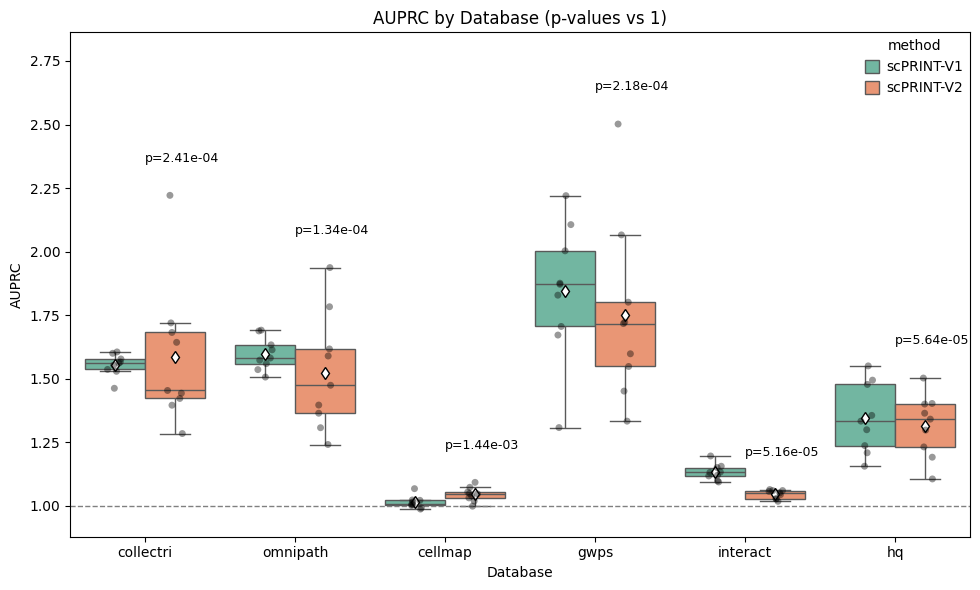

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_long,
    x="Database",
    y="AUPRC",
    hue="method",
    fliersize=0,
    palette="Set2",
    showmeans=True,
    meanprops={"marker": "d", "markerfacecolor": "white", "markeredgecolor": "black"},
)
sns.stripplot(
    data=df_long,
    x="Database",
    y="AUPRC",
    hue="method",
    palette=["black", "black"],  # Use black for both methods
    dodge=True,  # This aligns the strips with the boxplot groups
    alpha=0.4,
    size=5,
    legend=False,  # Avoid duplicate legend entries
)
# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long2["AUPRC"].max()
min_y = df_long2["AUPRC"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="left", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("AUPRC by Database (p-values vs 1)")
plt.xlabel("Database")
plt.ylabel("AUPRC")
plt.tight_layout()
plt.show()

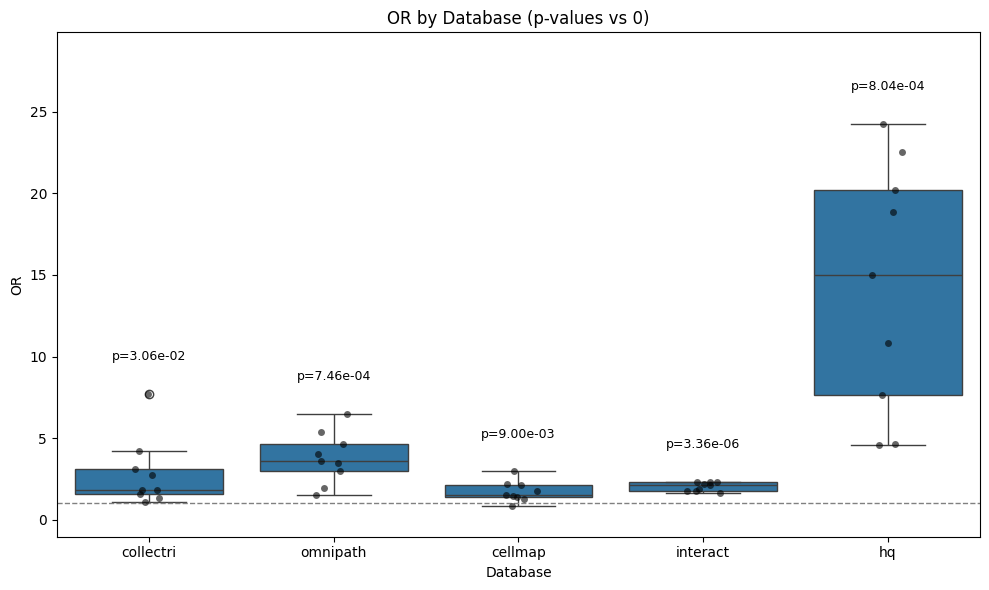

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

df = pd.DataFrame(
    {i: v for i, v in show.items() if "_odd_ratio" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Clean column names (remove '_auprc' suffix)
df.columns = [col.replace("_odd_ratio", "") for col in df.columns]

# Long format for seaborn
df_long = df.reset_index().melt(id_vars="index", var_name="Database", value_name="OR")
df_long = df_long.rename(columns={"index": "Cell Type"})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x="Database", y="OR")
sns.stripplot(data=df_long, x="Database", y="OR", color="k", alpha=0.6, size=5)

# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long["OR"].max()
min_y = df_long["OR"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("OR by Database (p-values vs 1)")
plt.xlabel("Database")
plt.ylabel("OR")
plt.tight_layout()
plt.show()

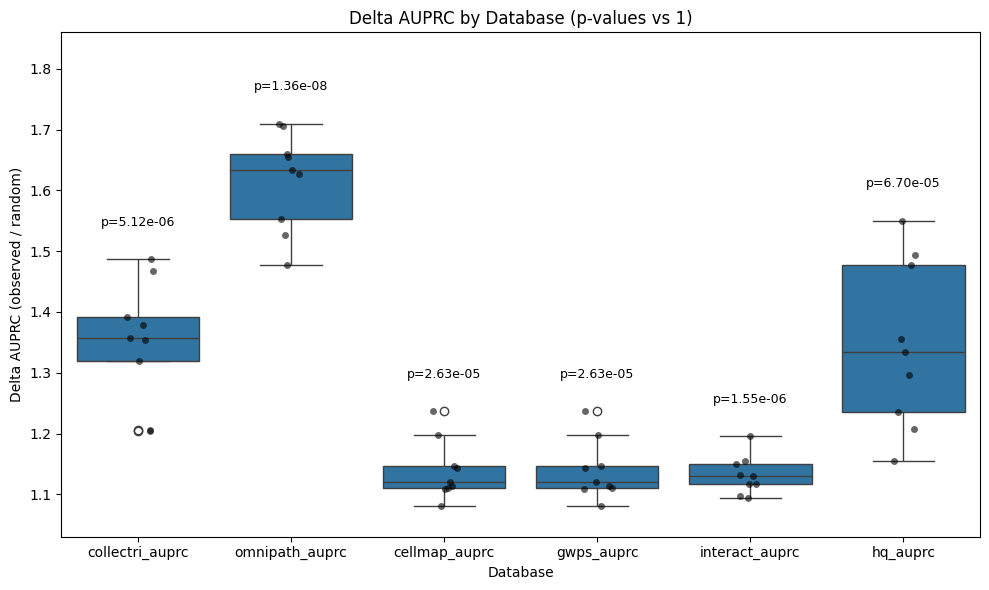

In [42]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_auprc" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Long format for seaborn
df_long = df.reset_index().melt(
    id_vars="index", var_name="Database", value_name="DeltaAUPRC"
)
df_long = df_long.rename(columns={"index": "Cell Type"})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x="Database", y="DeltaAUPRC")
sns.stripplot(data=df_long, x="Database", y="DeltaAUPRC", color="k", alpha=0.6, size=5)

# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long["DeltaAUPRC"].max()
min_y = df_long["DeltaAUPRC"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("Delta AUPRC by Database (p-values vs 1)")
plt.xlabel("Database")
plt.ylabel("Delta AUPRC (observed / random)")
plt.tight_layout()
plt.show()

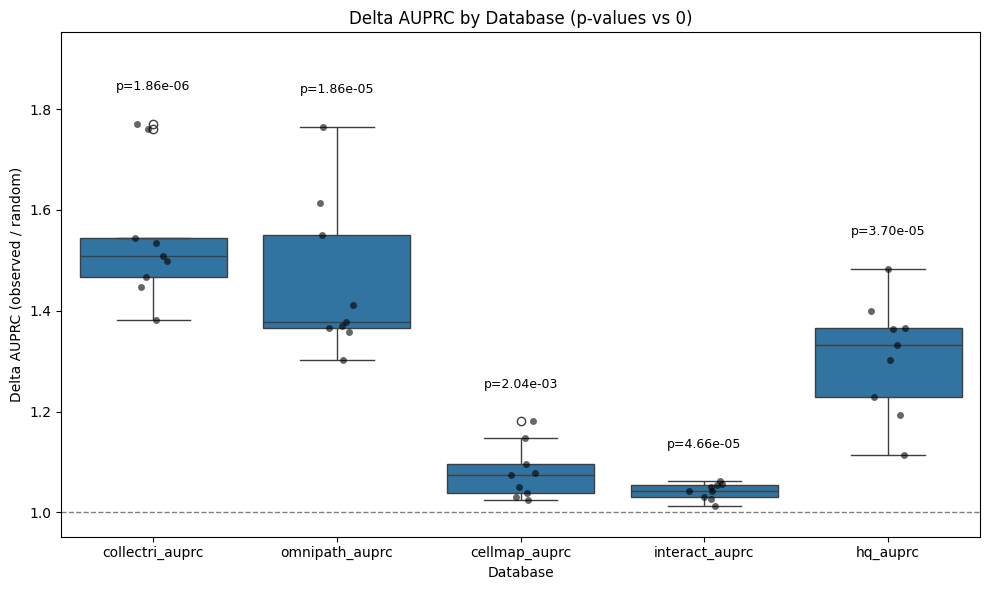

In [ ]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_auprc" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Long format for seaborn
df_long = df.reset_index().melt(
    id_vars="index", var_name="Database", value_name="DeltaAUPRC"
)
df_long = df_long.rename(columns={"index": "Cell Type"})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x="Database", y="DeltaAUPRC")
sns.stripplot(data=df_long, x="Database", y="DeltaAUPRC", color="k", alpha=0.6, size=5)

# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long["DeltaAUPRC"].max()
min_y = df_long["DeltaAUPRC"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("Delta AUPRC by Database (p-values vs 1)")
plt.xlabel("Database")
plt.ylabel("Delta AUPRC (observed / random)")
plt.tight_layout()
plt.show()